## DEPRECATED

This notebook is in the process of being deprecated with code being moved to several other notebooks, one per chart type.

Updates to chart code will be made in the new notebooks. This notebook will become a matter of historical interest only.

In [1]:
import sqlite3
import pandas as pd
%matplotlib inline

In [2]:
dbname='wrc18.db'
conn = sqlite3.connect(dbname)

q="SELECT name FROM sqlite_master WHERE type = 'table';"
pd.read_sql(q,conn)

,name
0,itinerary_event
1,itinerary_legs
2,itinerary_sections
3,itinerary_stages
4,itinerary_controls
5,startlists
6,startlist_classes
7,penalties
8,retirements
9,stagewinners


In [3]:
year=2018
rc='RC2'
ss='SS4'
rally='Sweden'

typ='stage_times_stage' #stage_times_stage stage_times_overall
typ='stage_times_overall'

## Stage Results

In [4]:
q='''
SELECT st.*, sc.name as class, i.code, i.distance, i.name, CAST(REPLACE(code,'SS','') AS INTEGER) snum,
sl.`driver.code`, sl.`entrant.name`
FROM {typ} st INNER JOIN itinerary_stages i ON st.stageId = i.stageId
INNER JOIN startlist_classes sc ON sc.entryid = st.entryId 
INNER JOIN championship_events ce ON i.eventId=ce.eventId
INNER JOIN startlists sl ON sl.entryId=sc.entryId
WHERE sc.name="{rc}" AND ce.`country.name`="{rally}" ORDER BY snum
'''.format(rc=rc,rally=rally, typ=typ)
stagerank=pd.read_sql(q,conn)

stagerank['classrank'] = stagerank.groupby(['snum'])['position'].rank(method='dense').astype(int)

stagerank.head(3)

,diffFirst,diffFirstMs,diffPrev,diffPrevMs,entryId,penaltyTime,penaltyTimeMs,position,stageTime,stageTimeMs,...,totalTimeMs,stageId,class,code,distance,name,snum,driver.code,entrant.name,classrank
0,PT4.1S,4100,PT0.6S,600,1589,PT0S,0,13,PT1M36.8S,96800,...,96800,317,RC2,SS1,1.9,SS1 SSS Karlstad 1,1,TID,Skoda Motorsport,1
1,PT4.2S,4200,PT0.1S,100,1590,PT0S,0,14,PT1M36.9S,96900,...,96900,317,RC2,SS1,1.9,SS1 SSS Karlstad 1,1,VEI,Skoda Motorsport,2
2,PT4.5S,4500,PT0.3S,300,1597,PT0S,0,15,PT1M37.2S,97200,...,97200,317,RC2,SS1,1.9,SS1 SSS Karlstad 1,1,ABB,Kevin Abbring,3


In [223]:
#Get differences in position and time to leader cf previous stage
stagerank['gainedPos'] = stagerank.groupby(['driver.code'])['position'].diff()<0 
stagerank['gainedTime'] = stagerank.groupby(['driver.code'])['diffFirstMs'].diff()<0 

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

%matplotlib inline

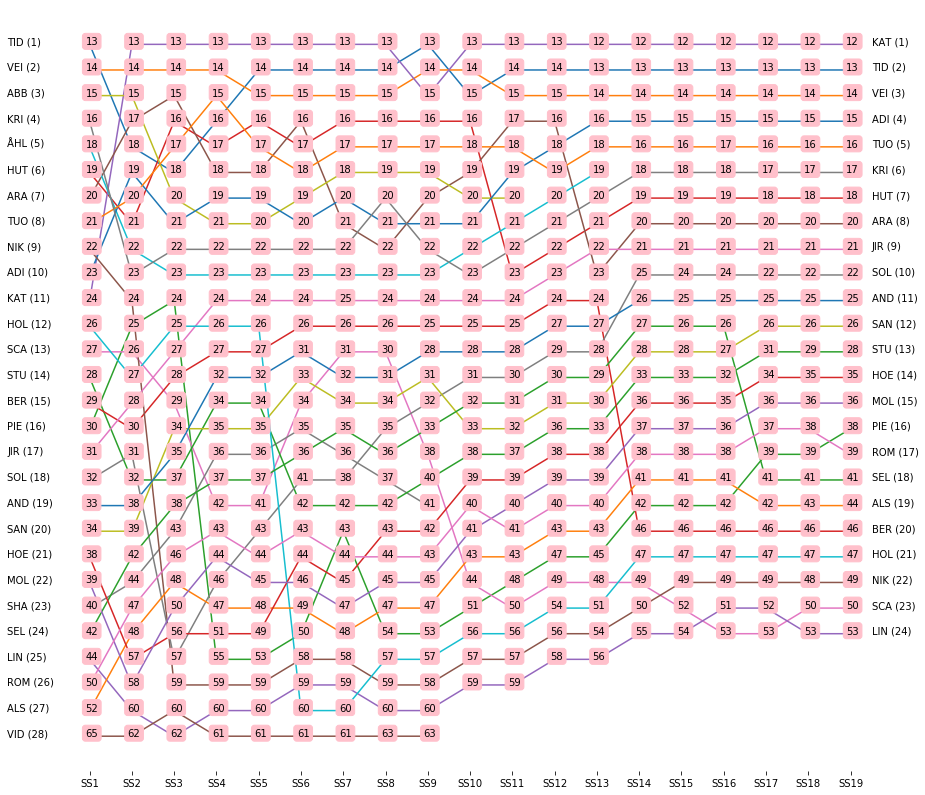

In [6]:
# Group properties
gc = stagerank
gcSize = len(gc['entryId'].unique()) #number of entries in class

rankpos='position'
#rankpos='classrank'

# Create plot
fig, ax = plt.subplots(figsize=(15,gcSize/2))

#Set blank axes
ax.xaxis.label.set_visible(False)
ax.get_yaxis().set_ticklabels([])
ax.set_yticks([]) 
ax.set_xticks([]) 

lhoffset=-1.95
rhoffset=+0.5

#labeler
addlabels = True
pinklabel= lambda x: int(x['position'])
#pinklabel= lambda x: int(x['classrank'])
#pinklabel= lambda x: x['driver.code']

ylabel = lambda x: x['driver.code']
ylabel = lambda x: int(x['position'])
ylabel = lambda x: int(x['classrank'])
ylabel = lambda x: '{} ({})'.format(x['driver.code'], int(x['classrank']))

gcSize=10

# Rally properties
smin = gc['snum'].min() # min stage number
smax = gc['snum'].max() # max stage number

# Define a dummy rank to provide compact ranking display
# This is primarily for RC1 which we expect to hold the top ranking positions overall
gc['xrank']= (gc[rankpos]>gcSize)
gc['xrank']=gc.groupby('snum')['xrank'].cumsum()
gc['xrank']=gc.apply(lambda row: row[rankpos] if row[rankpos]<=gcSize  else row['xrank'] +gcSize, axis=1)
    
#Base plot - line chart showing position of each driver against stages
gc.groupby('entryId').plot(x='snum',y='xrank',ax=ax,legend=None)

#Label cars ranked outside the group count - primarily for RC1
if addlabels:
    for i,d in gc[gc['xrank']>gcSize].iterrows():
        ax.text(d['snum']-0.1, d['xrank'], pinklabel(d),
                bbox=dict(  boxstyle='round,pad=0.3',color='pink')) #facecolor='none',edgecolor='black',

#Label driver names at left hand edge
for i,d in gc[gc['snum']==1].iterrows():
    ax.text(smin+lhoffset, d['xrank'], ylabel(d))
    
#Label driver names at right hand edge
for i,d in gc[gc['snum']==smax].iterrows():
    ax.text(smax+rhoffset, d['xrank'], ylabel(d))

# Label x-axis stage numbers
ax.set_xticks(stagerank['snum'].unique()) # choose which x locations to have ticks
ax.set_xticklabels(stagerank['code'].unique())

plt.gca().invert_yaxis()

#Hide outer box
plt.box(on=None)

In [7]:
#need a view that shows start number on stage versus final position on stage?

### Make  Functions For That...

In [585]:
#stage_times_stage, stage_times_overall

def stageClassEnrichers(stagerank):
    stagerank['classrank'] = stagerank.groupby(['snum'])['position'].rank(method='dense').astype(int)
    stagerank['gainedClassPos'] = stagerank.groupby(['driver.code'])['classrank'].diff()<0 
    stagerank['gainedClassLead'] = (stagerank.groupby(['driver.code'])['classrank'].diff()<0 ) & (stagerank['classrank']==1)
    stagerank['classPosDiff'] = stagerank.groupby(['driver.code'])['classrank'].diff().fillna(0)
    stagerank['lostClassLead'] = (stagerank['classrank']!=1) & (stagerank.groupby(['driver.code'])['classrank'].diff() == stagerank['classrank']-1)
    stagerank['retainedClassLead'] = ((stagerank['classrank'] ==1) & (~stagerank['gainedClassLead']) & (stagerank['snum']!=1))
    return stagerank

#https://stackoverflow.com/a/35428677/454773
def winningstreak(x):
    x['winsinarow'] = x.groupby( (x['position'] != 1).cumsum()).cumcount() +  ( (x['position'] != 1).cumsum() == 0).astype(int) 
    return x

def _debug_winningstreak(x):
    x['notwin'] = (x['position'] != 1)
    #The notwincumcount creates a new group for each not win
    #So if we have a streak of wins, the notwincumcount groups those together
    x['notwincumcount'] = x['notwin'].cumsum()
    x['startwithawin'] = (x['notwincumcount'] == 0).astype(int)
    #groupby.cumcount  - number each item in each group from 0 to the length of that group - 1.
    x['streakgroupwincount'] = x.groupby( 'notwincumcount' ).cumcount()

    x['winstreak'] = x.groupby( 'notwincumcount' ).cumcount() + x['startwithawin']
    return x

def stageOverallEnrichers(stagerank):
    stagerank['gainedOverallPos'] = stagerank.groupby(['driver.code'])['position'].diff()<0 
    stagerank['gainedOverallLead'] = (stagerank.groupby(['driver.code'])['position'].diff()<0 ) & (stagerank['position']==1)
    stagerank['overallPosDiff'] = stagerank.groupby(['driver.code'])['position'].diff().fillna(0)
    stagerank['lostOverallLead'] = (stagerank['position']!=1) & (stagerank.groupby(['driver.code'])['position'].diff() == stagerank['position']-1)
    stagerank['retainedOverallLead'] = ((stagerank['position'] ==1) & (~stagerank['gainedOverallLead']) & (stagerank['snum']!=1))

    stagerank['stagewin'] = stagerank['position']==1
    stagerank['stagewincount'] = stagerank.groupby(['driver.code'])['stagewin'].cumsum()

    stagerank = stagerank.groupby('driver.code').apply(winningstreak) 


    return stagerank
    
def stageTimeEnrichers(stagerank):
    stagerank['gainedTime'] = stagerank.groupby(['driver.code'])['diffFirstMs'].diff()<=0     
    return stagerank
    
def getStageRank(conn,rally,rc='RC1',typ='stage_times_overall'):
    q='''
    SELECT st.*, sc.name as class, i.code, i.distance, i.name, CAST(REPLACE(code,'SS','') AS INTEGER) snum,
    sl.`driver.code`, sl.`entrant.name`
    FROM {typ} st INNER JOIN itinerary_stages i ON st.stageId = i.stageId
    INNER JOIN startlist_classes sc ON sc.entryid = st.entryId 
    INNER JOIN championship_events ce ON i.eventId=ce.eventId
    INNER JOIN startlists sl ON sl.entryId=sc.entryId
    WHERE sc.name="{rc}" AND ce.`country.name`="{rally}" ORDER BY snum
    '''.format(rc=rc,rally=rally, typ=typ)
    stagerank=pd.read_sql(q,conn)
    
    return stagerank

def getEnrichedStageRank(conn,rally,rc='RC1',typ='stage_times_overall'):
    stagerank = getStageRank(conn,rally,rc,typ)
    stagerank = stageClassEnrichers(stagerank)
    stagerank = stageOverallEnrichers(stagerank)
    stagerank = stageTimeEnrichers(stagerank)
    return stagerank

In [608]:
def plotStageProgressionChart(gc, lhoffset=-0.5,rhoffset=0.5,linecolor=None,
                              deltalabels=False, progress=False, winstreak ='winsinarow'):
    entrySize = len(gc['entryId'].unique()) #number of entries in class

    progress = progress and 'leggainedpos' in gc.columns and 'leggainedtime' in gc.columns
    rankpos='position'
    #rankpos='classrank'

    # Rally properties
    smin = gc['snum'].min() # min stage number
    smax = gc['snum'].max() # max stage number
    
    # Create plot
    fig, ax = plt.subplots(figsize=(smax-smin,entrySize/2))

    #Set blank axes
    ax.xaxis.label.set_visible(False)
    ax.get_yaxis().set_ticklabels([])
    ax.set_yticks([]) 
    ax.set_xticks([]) 

    #labeler
    addlabels = True
    pinklabel= lambda x: int(x['position'])
    #pinklabel= lambda x: int(x['classrank'])
    #pinklabel= lambda x: x['driver.code']

    ylabel = lambda x: x['driver.code']
    ylabel = lambda x: int(x['position'])
    ylabel = lambda x: int(x['classrank'])
    ylabel = lambda x: '{} ({})'.format(x['driver.code'], int(x['classrank'])) 
     
    def elaboratelabel(x):
        if x['snum']==1:
            return '{} ({})'.format(x['driver.code'], int(x['classrank']))
        elif x['snum']==smin or not progress:
            txt='{} ({}: {})'
        elif x['leggainedpos'] and x['leggainedtime']:
            txt='{} ($\mathbf{{{}}}$: $\mathbf{{{}}}$)' 
        elif x['leggainedpos']:
            txt='{} ($\mathbf{{{}}}$: {})'
        elif x['leggainedtime']:
            txt='{} ({}: $\mathbf{{{}}}$)'
        else:  txt='{} ({}: {})'
        return txt.format(x['driver.code'], int(x['classrank']),x['diffFirst'].replace('PT','+').replace('S',''))
    ylabel= lambda x:elaboratelabel(x)
    gcSize=10
    
    ax.set_xlim(smin-0.2,smax+0.2)

    # Define a dummy rank to provide compact ranking display
    # This is primarily for RC1 which we expect to hold the top ranking positions overall
    gc['xrank'] = (gc[rankpos]>gcSize)
    gc['xrank'] = gc.groupby('snum')['xrank'].cumsum()
    gc['xrank'] = gc.apply(lambda row: row[rankpos] if row[rankpos]<=gcSize  else row['xrank'] +gcSize, axis=1)

    #Base plot - line chart showing position of each driver against stages
    gc.groupby('entryId').plot(x='snum',y='xrank',ax=ax,legend=None, color=linecolor)

    #test - lead data
    #for i,d in gc.iterrows():
    for i,d in gc[gc['position']==1].iterrows():
        resp=d[winstreak]#d['lostClassLead']#'1' if d['gainedLead'] else '0'
        ax.text(d['snum'], d['xrank'], resp,
               bbox=dict(  boxstyle='round,pad=0.3',color='lightgrey'),
               horizontalalignment='center')
    
    #Label cars ranked outside the group count - primarily for RC1
    if addlabels:
        for i,d in gc[gc['xrank']>gcSize].iterrows():
            if deltalabels: col='lightgreen' if d['gainedTime'] else 'pink'
            else: col ='pink'
            ax.text(d['snum'], d['xrank'], pinklabel(d),
                    bbox=dict(  boxstyle='round,pad=0.3',color=col),
                    horizontalalignment='center') #facecolor='none',edgecolor='black',

    #Stage time gain / loss indicator
    if deltalabels:
        for i,d in gc.iterrows():
            col='green' if d['gainedTime'] else 'red'
            ax.plot(d['snum'], d['xrank'], 'o', color=col)
    
    
    #Label driver names at left hand edge
    for i,d in gc[gc['snum']==smin].iterrows():
        ax.text(smin+lhoffset, d['xrank'], ylabel(d), horizontalalignment='right')

    #Label driver names at right hand edge
    for i,d in gc[gc['snum']==smax].iterrows():
        ax.text(smax+rhoffset, d['xrank'], ylabel(d), horizontalalignment='left')

    # Label x-axis stage numbers
    ax.set_xticks(gc['snum'].unique()) # choose which x locations to have ticks
    ax.set_xticklabels(gc['code'].unique())

    plt.gca().invert_yaxis()

    #Hide outer box
    plt.box(on=None)
    return fig,ax

In [609]:
stagerank[stagerank['driver.code']=='NEU']

,diffFirst,diffFirstMs,diffPrev,diffPrevMs,entryId,penaltyTime,penaltyTimeMs,position,stageTime,stageTimeMs,...,retainedClassLead,gainedOverallPos,gainedOverallLead,overallPosDiff,lostOverallLead,retainedOverallLead,stagewin,stagewincount,winsinarow,gainedTime
5,PT1S,1000,PT0.1S,100,1578,PT0S,0,6,PT1M33.7S,93700,...,False,False,False,0.0,False,False,False,0.0,0,False
17,PT7.5S,7500,PT0.5S,500,1578,PT0S,0,4,PT12M12.9S,732900,...,False,True,False,-2.0,False,False,False,0.0,0,False
28,PT0S,0,PT0S,0,1578,PT0S,0,1,PT25M29.3S,1529300,...,False,True,True,-3.0,False,False,True,1.0,1,True
42,PT0S,0,PT0S,0,1578,PT0S,0,1,PT35M49.7S,2149700,...,True,False,False,0.0,False,True,True,2.0,2,True
56,PT0S,0,PT0S,0,1578,PT0S,0,1,PT46M16.7S,2776700,...,True,False,False,0.0,False,True,True,3.0,3,True
70,PT0S,0,PT0S,0,1578,PT0S,0,1,PT59M38.1S,3578100,...,True,False,False,0.0,False,True,True,4.0,4,True
84,PT0S,0,PT0S,0,1578,PT0S,0,1,PT1H9M46.4S,4186400,...,True,False,False,0.0,False,True,True,5.0,5,True
98,PT0S,0,PT0S,0,1578,PT0S,0,1,PT1H16M13.1S,4573100,...,True,False,False,0.0,False,True,True,6.0,6,True
112,PT0S,0,PT0S,0,1578,PT0S,0,1,PT1H26M22.9S,5182900,...,True,False,False,0.0,False,True,True,7.0,7,True
126,PT0S,0,PT0S,0,1578,PT0S,0,1,PT1H39M30.4S,5970400,...,True,False,False,0.0,False,True,True,8.0,8,True


In [610]:
stagerank = getEnrichedStageRank(conn,rally)
stagerank.head(20)

,diffFirst,diffFirstMs,diffPrev,diffPrevMs,entryId,penaltyTime,penaltyTimeMs,position,stageTime,stageTimeMs,...,retainedClassLead,gainedOverallPos,gainedOverallLead,overallPosDiff,lostOverallLead,retainedOverallLead,stagewin,stagewincount,winsinarow,gainedTime
0,PT0S,0,PT0S,0,1581,PT0S,0,1,PT1M32.7S,92700,...,False,False,False,0.0,False,False,True,1.0,1,False
1,PT0.3S,300,PT0.3S,300,1580,PT0S,0,2,PT1M33S,93000,...,False,False,False,0.0,False,False,False,0.0,0,False
2,PT0.6S,600,PT0.3S,300,1585,PT0S,0,3,PT1M33.3S,93300,...,False,False,False,0.0,False,False,False,0.0,0,False
3,PT0.9S,900,PT0.3S,300,1583,PT0S,0,4,PT1M33.6S,93600,...,False,False,False,0.0,False,False,False,0.0,0,False
4,PT0.9S,900,PT0S,0,1577,PT0S,0,5,PT1M33.6S,93600,...,False,False,False,0.0,False,False,False,0.0,0,False
5,PT1S,1000,PT0.1S,100,1578,PT0S,0,6,PT1M33.7S,93700,...,False,False,False,0.0,False,False,False,0.0,0,False
6,PT2.1S,2100,PT1.1S,1100,1579,PT0S,0,7,PT1M34.8S,94800,...,False,False,False,0.0,False,False,False,0.0,0,False
7,PT2.2S,2200,PT0.1S,100,1582,PT0S,0,8,PT1M34.9S,94900,...,False,False,False,0.0,False,False,False,0.0,0,False
8,PT2.5S,2500,PT0.3S,300,1574,PT0S,0,9,PT1M35.2S,95200,...,False,False,False,0.0,False,False,False,0.0,0,False
9,PT2.9S,2900,PT0.4S,400,1584,PT0S,0,10,PT1M35.6S,95600,...,False,False,False,0.0,False,False,False,0.0,0,False


In [611]:
ssdemo = stagerank[stagerank['code'].isin(['SS2','SS3','SS4'])].copy()
lgp=(ssdemo.groupby('driver.code')['classrank'].agg('first')-ssdemo.groupby('driver.code')['classrank'].agg('last'))>0
ssdemo['leggainedpos']=ssdemo['driver.code'].map(lgp.to_dict())

tgp=(ssdemo.groupby('driver.code')['diffFirstMs'].agg('first')-ssdemo.groupby('driver.code')['diffFirstMs'].agg('last'))>=0
ssdemo['leggainedtime']=ssdemo['driver.code'].map(tgp.to_dict())

In [612]:
def stageLegEnrichers(legStagerank):
    lgp=(legStagerank.groupby('driver.code')['classrank'].agg('first')-legStagerank.groupby('driver.code')['classrank'].agg('last'))>0
    legStagerank['leggainedpos']=ssdemo['driver.code'].map(lgp.to_dict())

    tgp=(legStagerank.groupby('driver.code')['diffFirstMs'].agg('first')-legStagerank.groupby('driver.code')['diffFirstMs'].agg('last'))>=0
    legStagerank['leggainedtime']=legStagerank['driver.code'].map(tgp.to_dict())
    
    legStagerank['legstagewincount'] = legStagerank.groupby(['driver.code'])['stagewin'].cumsum()

    legStagerank = legStagerank.groupby('driver.code').apply(winningstreak) 
    return legStagerank


In [613]:
ssdemo = stagerank[stagerank['code'].isin(['SS2','SS3','SS4'])].copy()
ssdemo = stageLegEnrichers(ssdemo)

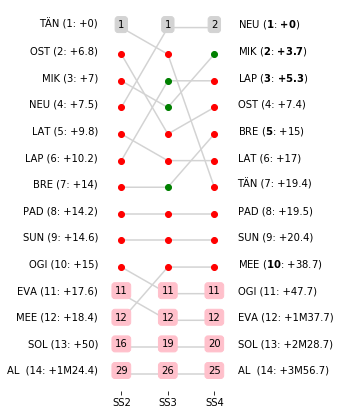

In [614]:
fig, ax = plotStageProgressionChart( ssdemo,linecolor='lightgrey' , deltalabels=True,progress=True);

#fig, ax = plotStageProgressionChart( stagerank,deltalabels=True );

In [497]:
q='''
SELECT il.legDate, il.name AS date, il.startListId, il.status,
    isc.itineraryLegId, isc.itinerarySectionId, isc.name AS section, isc.`order`,
    ist.* FROM championship_events ce 
JOIN itinerary_event ie ON ce.eventId = ie.eventId 
JOIN itinerary_legs il ON ie.itineraryId=il.itineraryId
JOIN itinerary_sections isc ON il.itineraryLegId=isc.itineraryLegId
JOIN itinerary_stages ist ON ist.`itinerarySections.itinerarySectionId`=isc.itinerarySectionId
WHERE ce.`country.name`="{rally}" ORDER BY isc.`order`
'''.format(rally=rally)
rally_stages = pd.read_sql(q,conn)
rally_stages.head(3)

,legDate,date,startListId,status,itineraryLegId,itinerarySectionId,section,order,code,distance,eventId,name,number,stageId,stageType,status,timingPrecision,itineraryLegId,itinerarySections.itinerarySectionId
0,2018-02-15,Thursday 15 February,74,Completed,53,117,Section 1,1,SS1,1.90,27,SS1 SSS Karlstad 1,1,317,HeadToHeadSuperSpecialStage,Completed,Tenth,53,117
1,2018-02-16,Friday 16 February,78,Completed,54,118,Section 2,2,SS2,21.26,27,SS2 Hof-Finnskog 1,2,299,SpecialStage,Completed,Tenth,54,118
2,2018-02-16,Friday 16 February,78,Completed,54,118,Section 2,2,SS3,24.88,27,SS3 Svullrya 1,3,300,SpecialStage,Completed,Tenth,54,118


In [616]:
rally_stages.groupby('section')['number'].max()


section
Section 1     1
Section 2     4
Section 3     8
Section 4    11
Section 5    14
Section 6    16
Section 7    17
Section 8    18
Section 9    19
Name: number, dtype: int64

In [617]:
#for a in ax.get_xticklabels(): print(a.get_text(), a.get_position())

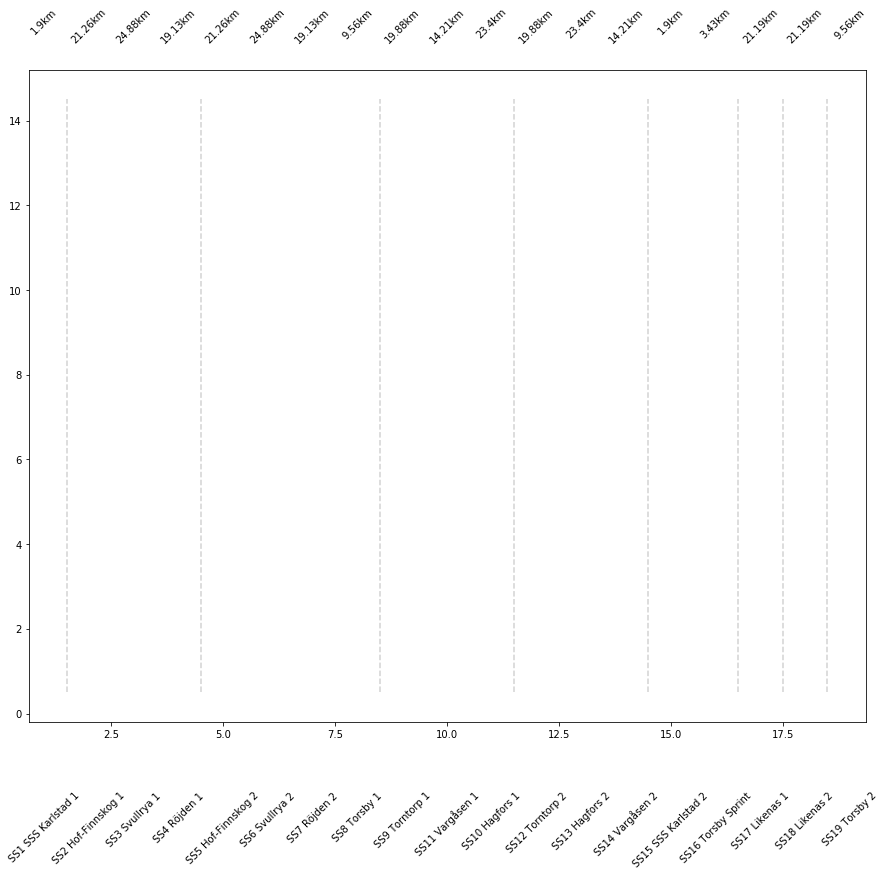

In [618]:
ll=len(stagerank['driver.code'].unique())
for i,d in rally_stages.iterrows():
    #Show stage distance
    ax.text(i+1,2.5+ll,'{}km'.format(d['distance']),
            horizontalalignment='center',fontsize=10, rotation=45)
    #Show stage name
    ax.text(i+1,-2,'{}'.format(d['name']),
            horizontalalignment='center',fontsize=10, rotation=45)
#Separate out the separate sections
for i in rally_stages.groupby('section')['number'].max()[:-1]:
    ax.plot((i+0.5,i+0.5), (0.5,ll+0.5), color='lightgrey', linestyle='dashed')
fig

## Rally Delta Charts

Macroscope intended to show gaps between cars on each stage of a rally.

In [619]:
rebase= stagerank[stagerank['position']==1][['snum','totalTimeMs']].set_index('snum').to_dict(orient='dict')['totalTimeMs']
rebase

{1: 92700,
 2: 725400,
 3: 1529300,
 4: 2149700,
 5: 2776700,
 6: 3578100,
 7: 4186400,
 8: 4573100,
 9: 5182900,
 10: 5970400,
 11: 6486300,
 12: 7082900,
 13: 7847400,
 14: 8355600,
 15: 8451100,
 16: 8603800,
 17: 9291800,
 18: 9968700,
 19: 10333100}

In [620]:
stagerank.head()

,diffFirst,diffFirstMs,diffPrev,diffPrevMs,entryId,penaltyTime,penaltyTimeMs,position,stageTime,stageTimeMs,...,retainedClassLead,gainedOverallPos,gainedOverallLead,overallPosDiff,lostOverallLead,retainedOverallLead,stagewin,stagewincount,winsinarow,gainedTime
0,PT0S,0,PT0S,0,1581,PT0S,0,1,PT1M32.7S,92700,...,False,False,False,0.0,False,False,True,1.0,1,False
1,PT0.3S,300,PT0.3S,300,1580,PT0S,0,2,PT1M33S,93000,...,False,False,False,0.0,False,False,False,0.0,0,False
2,PT0.6S,600,PT0.3S,300,1585,PT0S,0,3,PT1M33.3S,93300,...,False,False,False,0.0,False,False,False,0.0,0,False
3,PT0.9S,900,PT0.3S,300,1583,PT0S,0,4,PT1M33.6S,93600,...,False,False,False,0.0,False,False,False,0.0,0,False
4,PT0.9S,900,PT0S,0,1577,PT0S,0,5,PT1M33.6S,93600,...,False,False,False,0.0,False,False,False,0.0,0,False


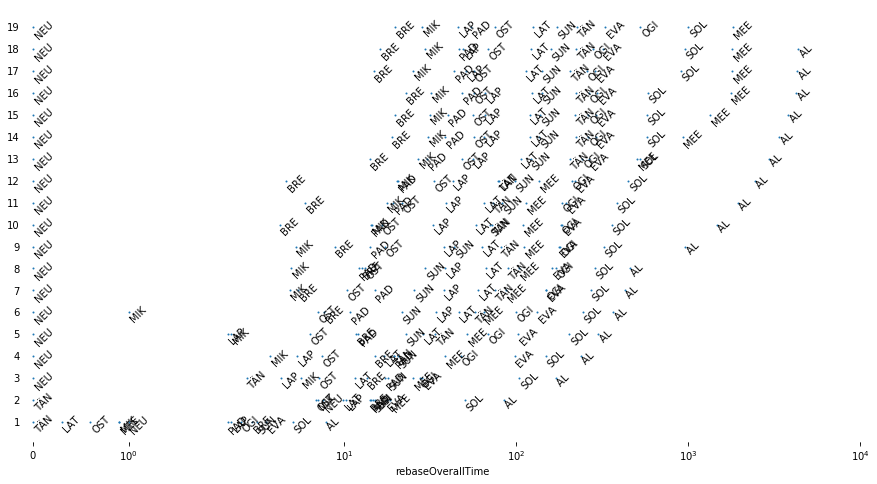

In [621]:
## Plot Stage Times
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(15,8))
ax.yaxis.label.set_visible(False)
ax.tick_params(axis='y', which='both',length=0)
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.xscale('symlog')
plt.box(on=None)
stagerank['rebaseOverallTime']  = ((stagerank['totalTimeMs'] - stagerank['snum'].map(rebase))/1000).round(1)
stagerank.plot(kind='scatter',y='snum',x='rebaseOverallTime',xlim=(-0.1,10000),s=1,ax=ax )

for i, row in stagerank.iterrows():
    ax.annotate(row['driver.code'], (stagerank.iloc[i]['rebaseOverallTime'],stagerank.iloc[i]['snum']), rotation=45)

In [622]:
#show deltas for target driver
drivercode='OST'
rebase= stagerank[stagerank['driver.code']==drivercode][['snum','totalTimeMs']].set_index('snum').to_dict(orient='dict')['totalTimeMs']
rebase

{1: 93300,
 2: 732200,
 3: 1536400,
 4: 2157100,
 5: 2783000,
 6: 3585100,
 7: 4196800,
 8: 4586300,
 9: 5200100,
 10: 5987000,
 11: 6507800,
 12: 7115900,
 13: 7895400,
 14: 8412100,
 15: 8507100,
 16: 8660600,
 17: 9348200,
 18: 10037300,
 19: 10408400}

In [3]:
def plotDeltaLabels(stagerank, rebaseType='position',drivercode=None, logscale=True,xlim=None, ylim=None, title=None):
    ''' rebaseType: driver | position '''
    if rebaseType=='driver' and drivercode is not None:
        rebase= stagerank[stagerank['driver.code']==drivercode][['snum','totalTimeMs']].set_index('snum').to_dict(orient='dict')['totalTimeMs']
    else:
        rebase= stagerank[stagerank['position']==1][['snum','totalTimeMs']].set_index('snum').to_dict(orient='dict')['totalTimeMs']

    fig, ax = plt.subplots(figsize=(15,8))
    plt.box(on=None)
    
    ax.yaxis.label.set_visible(False)
    ax.tick_params(axis='y', which='both',length=0)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    
    if logscale:
        plt.xscale('symlog')
    
    plt.axvline(x=0,linestyle='dashed',color='grey')
    
    title = 'Overall Deltas by Stage' if title is None else title
    title = '{} (relative to {})'.format(title, drivercode) if drivercode else title
    
    stagerank['rebaseOverallTime']  = ((stagerank['totalTimeMs'] - stagerank['snum'].map(rebase))/1000).round(1)
    stagerank.plot(kind='scatter',y='snum',x='rebaseOverallTime',s=1,ax=ax, xlim=xlim, ylim=ylim ,
                   title = title)

    for i, row in stagerank.iterrows():
        if xlim is not None:
            if stagerank.iloc[i]['rebaseOverallTime']>=xlim[0] and stagerank.iloc[i]['rebaseOverallTime']<=xlim[1]:
                if row['driver.code'] != drivercode:
                    col='g' if row['rebaseOverallTime']<0 else 'r'
                    txt = '{} [{}]'.format(row['driver.code'],row['position'])
                else:
                    col='black'
                    txt = row['position']
                
                ax.annotate(txt,
                            (row['rebaseOverallTime'],row['snum']),color=col, rotation=45)

In [ ]:
plotDeltaLabels(stagerank, 'driver','PAD',logscale=False,xlim=(-20,20))

## Split times on a Stage

In [625]:
rc='RC1'

q='''
SELECT st.*, sc.name as class, i.code, i.distance, i.name, sl.`driver.code` drivercode
FROM split_times st INNER JOIN itinerary_stages i ON st.stageid = i.stageid
INNER JOIN startlist_classes sc ON sc.entryid = st.entryid 
INNER JOIN championship_events ce ON i.eventId=ce.eventId
INNER JOIN startlists sl ON sl.entryId=sc.entryId
WHERE i.code="{ss}" AND sc.name="{rc}" AND ce.`country.name`="{rally}" ORDER BY startDateTime,entryId, splitDateTime
'''.format(rc=rc,ss=ss, rally=rally)
splits=pd.read_sql(q,conn)
splits.head()

,elapsedDuration,elapsedDurationMs,entryId,splitDateTime,splitDateTimeLocal,splitPointId,splitPointTimeId,stageTimeDuration,stageTimeDurationMs,startDateTime,startDateTimeLocal,stageId,class,code,distance,name,drivercode
0,PT1M28.059S,88059,1574,2018-02-16T08:55:28.059Z,2018-02-16T09:55:28.059+01:00,661,16671,00:10:40.5000000,640500.0,2018-02-16T08:54:00,2018-02-16T09:54:00+01:00,301,RC1,SS4,19.13,SS4 Röjden 1,OGI
1,PT4M11.143S,251143,1574,2018-02-16T08:58:11.143Z,2018-02-16T09:58:11.143+01:00,683,16503,00:10:40.5000000,640500.0,2018-02-16T08:54:00,2018-02-16T09:54:00+01:00,301,RC1,SS4,19.13,SS4 Röjden 1,OGI
2,PT6M49.659S,409659,1574,2018-02-16T09:00:49.659Z,2018-02-16T10:00:49.659+01:00,688,16683,00:10:40.5000000,640500.0,2018-02-16T08:54:00,2018-02-16T09:54:00+01:00,301,RC1,SS4,19.13,SS4 Röjden 1,OGI
3,PT9M5.5S,545500,1574,2018-02-16T09:03:05.5Z,2018-02-16T10:03:05.5+01:00,690,16690,00:10:40.5000000,640500.0,2018-02-16T08:54:00,2018-02-16T09:54:00+01:00,301,RC1,SS4,19.13,SS4 Röjden 1,OGI
4,PT1M27.079S,87079,1581,2018-02-16T08:56:27.079Z,2018-02-16T09:56:27.079+01:00,661,16509,00:10:37.1000000,637100.0,2018-02-16T08:55:00,2018-02-16T09:55:00+01:00,301,RC1,SS4,19.13,SS4 Röjden 1,TÄN


## Deltas within a particular sector

In [626]:
splits['splitDurationMs']=splits.groupby('drivercode')['elapsedDurationMs'].transform(pd.Series.diff)
#splits.loc[0, 'splitDurationMs'] = splits['elapsedDurationMs'].iloc[0]
#Set the value of the first difference to be the original split time
splits.loc[splits.groupby('drivercode',as_index=False).head(1).index,'splitDurationMs'] = splits.loc[splits.groupby('drivercode',as_index=False).head(1).index,'elapsedDurationMs']
splits['splitDurationS']=(splits['splitDurationMs']/1000).round(1)
#splits['splitnum'] = splits.groupby('drivercode').cumcount()+1
splits.head()

,elapsedDuration,elapsedDurationMs,entryId,splitDateTime,splitDateTimeLocal,splitPointId,splitPointTimeId,stageTimeDuration,stageTimeDurationMs,startDateTime,startDateTimeLocal,stageId,class,code,distance,name,drivercode,splitDurationMs,splitDurationS
0,PT1M28.059S,88059,1574,2018-02-16T08:55:28.059Z,2018-02-16T09:55:28.059+01:00,661,16671,00:10:40.5000000,640500.0,2018-02-16T08:54:00,2018-02-16T09:54:00+01:00,301,RC1,SS4,19.13,SS4 Röjden 1,OGI,88059.0,88.1
1,PT4M11.143S,251143,1574,2018-02-16T08:58:11.143Z,2018-02-16T09:58:11.143+01:00,683,16503,00:10:40.5000000,640500.0,2018-02-16T08:54:00,2018-02-16T09:54:00+01:00,301,RC1,SS4,19.13,SS4 Röjden 1,OGI,163084.0,163.1
2,PT6M49.659S,409659,1574,2018-02-16T09:00:49.659Z,2018-02-16T10:00:49.659+01:00,688,16683,00:10:40.5000000,640500.0,2018-02-16T08:54:00,2018-02-16T09:54:00+01:00,301,RC1,SS4,19.13,SS4 Röjden 1,OGI,158516.0,158.5
3,PT9M5.5S,545500,1574,2018-02-16T09:03:05.5Z,2018-02-16T10:03:05.5+01:00,690,16690,00:10:40.5000000,640500.0,2018-02-16T08:54:00,2018-02-16T09:54:00+01:00,301,RC1,SS4,19.13,SS4 Röjden 1,OGI,135841.0,135.8
4,PT1M27.079S,87079,1581,2018-02-16T08:56:27.079Z,2018-02-16T09:56:27.079+01:00,661,16509,00:10:37.1000000,637100.0,2018-02-16T08:55:00,2018-02-16T09:55:00+01:00,301,RC1,SS4,19.13,SS4 Röjden 1,TÄN,87079.0,87.1


In [627]:
#Find the time for the last section - i.e. diff between stage time and final split time
tmp = splits.groupby('drivercode', as_index=False).last()[['drivercode','stageTimeDurationMs','elapsedDurationMs', 'startDateTime' ]]
tmp['splitDurationS']=((tmp['stageTimeDurationMs']-tmp['elapsedDurationMs'])/1000).round(1)
tmp

,drivercode,stageTimeDurationMs,elapsedDurationMs,startDateTime,splitDurationS
0,AL,687600.0,594275,2018-02-16T09:20:00,93.3
1,BRE,621900.0,533370,2018-02-16T09:10:00,88.5
2,EVA,689800.0,577005,2018-02-16T09:03:00,112.8
3,LAP,621400.0,532025,2018-02-16T09:06:00,89.4
4,LAT,625900.0,533383,2018-02-16T08:58:00,92.5
5,MEE,633900.0,540520,2018-02-16T09:00:00,93.4
6,MIK,618500.0,529534,2018-02-16T09:08:00,89.0
7,NEU,620400.0,530569,2018-02-16T09:02:00,89.8
8,OGI,640500.0,545500,2018-02-16T08:54:00,95.0
9,OST,620700.0,532727,2018-02-16T09:16:00,88.0


In [628]:
cols = ['drivercode','splitDurationS', 'startDateTime','stageTimeDurationMs']
splitdurations = pd.concat([splits[cols],tmp[cols]]).reset_index(drop=True)
splitdurations['section'] = splitdurations.groupby('drivercode').cumcount()+1
splitdurations = splitdurations.sort_values(['startDateTime','drivercode','section'])
splitdurations.head()

,drivercode,splitDurationS,startDateTime,stageTimeDurationMs,section
0,OGI,88.1,2018-02-16T08:54:00,640500.0,1
1,OGI,163.1,2018-02-16T08:54:00,640500.0,2
2,OGI,158.5,2018-02-16T08:54:00,640500.0,3
3,OGI,135.8,2018-02-16T08:54:00,640500.0,4
63,OGI,95.0,2018-02-16T08:54:00,640500.0,5


### Make That a Function

In [629]:
def getSplits(conn,rally,ss,rc='RC1'):
    q='''
    SELECT st.*, sc.name as class, i.code, i.distance, i.name, sl.`driver.code` drivercode
    FROM split_times st INNER JOIN itinerary_stages i ON st.stageid = i.stageid
    INNER JOIN startlist_classes sc ON sc.entryid = st.entryid 
    INNER JOIN championship_events ce ON i.eventId=ce.eventId
    INNER JOIN startlists sl ON sl.entryId=sc.entryId
    WHERE i.code="{ss}" AND sc.name="{rc}" AND ce.`country.name`="{rally}" ORDER BY startDateTime,entryId, splitDateTime
    '''.format(rc=rc,ss=ss, rally=rally)
    splits=pd.read_sql(q,conn)
    return splits

def _getSplitDurationsFromSplits(splits):
        
    splits['splitDurationMs']=splits.groupby('drivercode')['elapsedDurationMs'].transform(pd.Series.diff)
    #Set the value of the first difference to be the original split time
    splits.loc[splits.groupby('drivercode',as_index=False).head(1).index,'splitDurationMs'] = splits.loc[splits.groupby('drivercode',as_index=False).head(1).index,'elapsedDurationMs']
    splits['splitDurationS']=(splits['splitDurationMs']/1000).round(1)

    #Find the time for the last section - i.e. diff between stage time and final split time
    tmp = splits.groupby('drivercode', as_index=False).last()[['drivercode','stageTimeDurationMs','elapsedDurationMs', 'startDateTime' ]]
    tmp['splitDurationS']=((tmp['stageTimeDurationMs']-tmp['elapsedDurationMs'])/1000).round(1)

    cols = ['drivercode','splitDurationS', 'startDateTime','stageTimeDurationMs']
    splitdurations = pd.concat([splits[cols],tmp[cols]]).reset_index(drop=True)
    splitdurations['section'] = splitdurations.groupby('drivercode').cumcount()+1
    splitdurations = splitdurations.sort_values(['startDateTime','drivercode','section'])

    return splitdurations

def getSplitDurationsFromSplits(conn,rally,ss,rc='RC1'):
    splits = getSplits(conn,rally,ss,rc='RC1')
    return _getSplitDurationsFromSplits(splits)

## Rebasing

The aim of rebasing is to derive time deltas for one car relative to times recorded by an arbitrary other car.

The first step is to capture the base times for the target vehicle, relative to which rebased times will be calculated.

In [630]:
drivercode = 'OGI'

rebase = splitdurations[splitdurations['drivercode']==drivercode][['section','splitDurationS']].set_index('section').to_dict(orient='dict')['splitDurationS']
rebase

{1: 88.1, 2: 163.1, 3: 158.5, 4: 135.8, 5: 95.0}

The base times are then subtracted from the corresponding times for each other car.

In [631]:
splitdurations['rebased'] = splitdurations['splitDurationS'] - splitdurations['section'].map(rebase)

In [632]:
splitdurations['section'] = splitdurations['section']#.astype(str)
splitdurations.head()

,drivercode,splitDurationS,startDateTime,stageTimeDurationMs,section,rebased
0,OGI,88.1,2018-02-16T08:54:00,640500.0,1,0.0
1,OGI,163.1,2018-02-16T08:54:00,640500.0,2,0.0
2,OGI,158.5,2018-02-16T08:54:00,640500.0,3,0.0
3,OGI,135.8,2018-02-16T08:54:00,640500.0,4,0.0
63,OGI,95.0,2018-02-16T08:54:00,640500.0,5,0.0


### Make That a Function

In [633]:
def rebaseSplitDurations(splitdurations, drivercode=None):
    if drivercode is None: return splitdurations
    
    rebase = splitdurations[splitdurations['drivercode']==drivercode][['section','splitDurationS']].set_index('section').to_dict(orient='dict')['splitDurationS']
    splitdurations['rebased'] = splitdurations['splitDurationS'] - splitdurations['section'].map(rebase)
    return splitdurations
    

In [634]:
def rebaseSplitDurationsBest(splitdurations):
    
    #Note this ranking may include undersired drivers w/ bad data
    if 'sectorrank' not in splitdurations:
        splitdurations['sectorrank']=splitdurations.groupby(['section'])['splitDurationS'].rank(method='dense').astype(int)

    rebase = splitdurations[splitdurations['sectorrank']==1][['section','splitDurationS']].set_index('section').to_dict(orient='dict')['splitDurationS']
    splitdurations['rebased'] = splitdurations['splitDurationS'] - splitdurations['section'].map(rebase)

    sectorPurpleDriver = splitdurations[splitdurations['sectorrank']==1][['section','drivercode']].set_index('section').to_dict(orient='dict')['drivercode']
    splitdurations['sectorBestDriver'] = splitdurations['section'].map(sectorPurpleDriver)
    return splitdurations


We can define a sort order for the display of times grouped by drivers.

## Plot Split Derived Sectors

In [635]:
order = splitdurations.sort_values(['stageTimeDurationMs','drivercode'])['drivercode'].unique().tolist()

In [636]:
#rebaseSplitDurations(splitdurations, drivercode=None).pivot('drivercode','section','rebased')

In [637]:
splitdurations.pivot('drivercode','section','rebased')

section,1,2,3,4,5
drivercode,,,,,
AL,10.2,19.2,16.2,3.2,-1.7
BRE,-0.4,-0.7,-2.8,-8.3,-6.5
EVA,1.0,0.5,7.7,22.3,17.8
LAP,158.4,-6.8,-29.3,-46.4,NaN
LAT,-0.8,-2.0,-3.3,-6.0,-2.5
MEE,0.2,0.3,-0.8,-4.7,-1.6
MIK,-1.5,-3.0,-2.8,-8.6,-6.0
NEU,-2.5,-1.3,-3.3,-7.8,-5.2
OGI,0.0,0.0,0.0,0.0,0.0


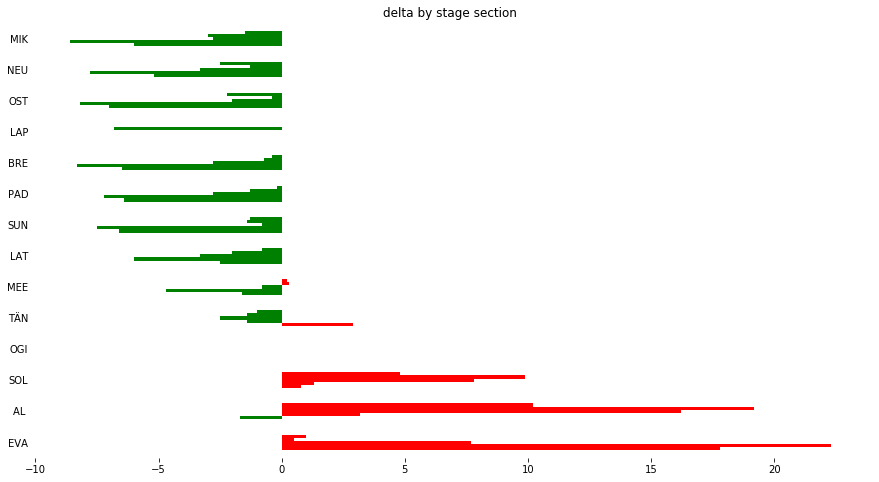

In [638]:
fig, ax = plt.subplots(figsize=(15,8))
ax.yaxis.label.set_visible(False)
ax.tick_params(axis='y', which='both',length=0)

zz=splitdurations[splitdurations['rebased'].abs()<25].pivot('drivercode','section','rebased')
#zz['stagediff']=zz.sum(axis=1)
#zz = zz.sort_values('stagediff',ascending=True).drop(['stagediff'], axis=1)
zz=zz.reindex(order)


#Define a color map for the bars
#This is based on generating a list of lists.
#The outer list represents the cars; each inner list represents the bar colours grouped for each car.
#In this case, we define colours based on positive or negative deltas relative to the target car.
cmap=[]
for col in zz.columns:
    cmap.append( ['r' if x else 'g' for x in zz[col]>0 ] )

zz.plot(kind='barh',title='delta by stage section',color=cmap,ax=ax, legend=False).invert_yaxis()

#Hide outer box
plt.box(on=None)


In the above chart, we see times relative to OGI. The drivers are ordered based on overall stage time. The grouped bars show the delta to the target driver within each "sector" of the stage, with the first sector at the top of the grouping and the last sector at the bottom.

In this case, we see OGI lost time on each sector relative to 7 of the top 8 cars (in this particular example, the times for LAP appear to be corrupt).

The color selection reflects the perspective with which we read the chart. In the above case, the red colour indicates that the target drive lost time compared to the drivers ahead on the stage. The negative x-axis time shoud be read as indicating that the the driver lost that amount of time relative those cars (i.e. the target river is negatively affected by those times).

The green colouring suggests that the target driver *gained* time against the lesser ranked cars, making up "positive" seconds against them.

In [639]:
zz.columns=['SS{}'.format(c) for c in zz.columns]
zz.head()

,SS1,SS2,SS3,SS4,SS5
drivercode,,,,,
MIK,-1.5,-3.0,-2.8,-8.6,-6.0
NEU,-2.5,-1.3,-3.3,-7.8,-5.2
OST,-2.2,-0.4,-2.0,-8.2,-7.0
LAP,NaN,-6.8,NaN,NaN,NaN
BRE,-0.4,-0.7,-2.8,-8.3,-6.5


In [640]:
#This requires all the split times to be in
#zz['total']=zz.sum(axis=1)
#Better to use the actual stage delta time?
zz['total']=(splitdurations[['drivercode','stageTimeDurationMs']].drop_duplicates().set_index('drivercode')/1000).round(1)
rebase = ((splitdurations[splitdurations['drivercode']==drivercode][['section','stageTimeDurationMs']].iloc[0]['stageTimeDurationMs'])/1000).round(1)
zz['total'] = zz['total'] - rebase 
zz.head()

,SS1,SS2,SS3,SS4,SS5,total
drivercode,,,,,,
MIK,-1.5,-3.0,-2.8,-8.6,-6.0,-22.0
NEU,-2.5,-1.3,-3.3,-7.8,-5.2,-20.1
OST,-2.2,-0.4,-2.0,-8.2,-7.0,-19.8
LAP,NaN,-6.8,NaN,NaN,NaN,-19.1
BRE,-0.4,-0.7,-2.8,-8.3,-6.5,-18.6


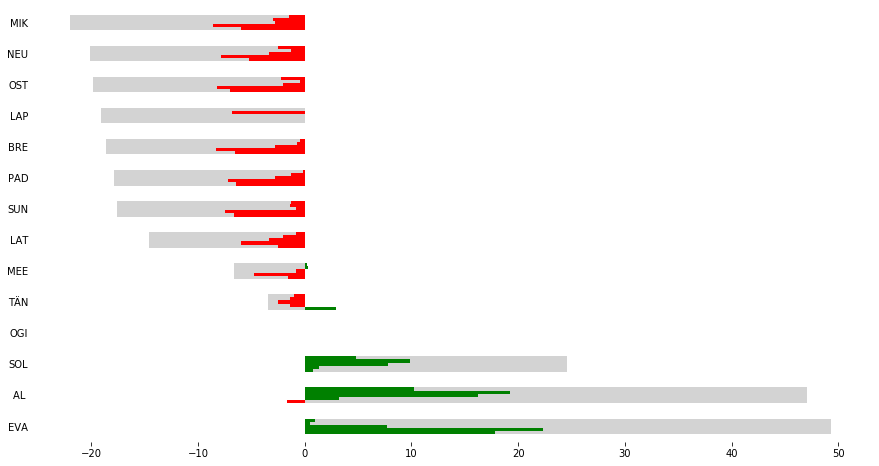

In [641]:
fig, ax = plt.subplots(figsize=(15,8))
ax.yaxis.label.set_visible(False)
ax.tick_params(axis='y', which='both',length=0)

#Define a color map for the bars
#This is based on generating a list of lists.
#The outer list represents the cars; each inner list represents the bar colours grouped for each car.
#In this case, we define colours based on positive or negative deltas relative to the target car.
cmap=[]

cols=[c for c in zz.columns if c.startswith('SS')]
for col in cols:
    cmap.append( ['g' if x else 'r' for x in zz[col]>0 ] )

zz['total'].plot(kind='barh',ax=ax, color='lightgrey',legend=False)

zz[cols].plot(kind='barh',color=cmap,ax=ax, legend=False).invert_yaxis()

#Hide outer box
plt.box(on=None)


### Make Functions of Those

In [642]:
def getSplitOrderByStageTimeDuration(splitdurations):
    return splitdurations.sort_values(['stageTimeDurationMs','drivercode'])['drivercode'].unique().tolist()

def plotSplitSectionDelta(splitdurations, drivercode=None, order=None,
                          fig=None,ax=None, alpha=1, pos='r', neg='g', total=False,invert_yaxis=True,
                          ignoresplitsfordrivercodes=None):

    splitdurations = rebaseSplitDurations(splitdurations, drivercode)
    if 'rebased' not in splitdurations: return
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))
        
        ax.yaxis.label.set_visible(False)
        ax.tick_params(axis='y', which='both',length=0)
        #Hide outer box
        plt.box(on=None)

    #zz=splitdurations[splitdurations['rebased'].abs()<25].pivot('drivercode','section','rebased')
    zz=splitdurations.pivot('drivercode','section','rebased')
    if order is None:
        order = getSplitOrderByStageTimeDuration(splitdurations)
    zz=zz.reindex(order)
    
    if total:
        #zz.sum(axis=1).plot(kind='barh',ax=ax, color='lightgrey',legend=False)
        _total=(splitdurations[['drivercode','stageTimeDurationMs']].drop_duplicates().set_index('drivercode')/1000).round(1)
        rebase = ((splitdurations[splitdurations['drivercode']==drivercode][['section','stageTimeDurationMs']].iloc[0]['stageTimeDurationMs'])/1000).round(1)
        _total = _total - rebase 
        _total.reindex(order).plot(kind='barh',ax=ax, color='lightgrey',legend=False)

    if ignoresplitsfordrivercodes is not None:
        ignoresplitsfordrivercodes = [ignoresplitsfordrivercodes] if not isinstance(ignoresplitsfordrivercodes,list) else ignoresplitsfordrivercodes
        zz = zz[~zz.index.isin(ignoresplitsfordrivercodes)]
        
    cmap=[]
    
    #Need to set the column order to plot splits correctly
    cols=zz.columns[::-1] if not invert_yaxis else zz.columns
    
    for col in cols:
        cmap.append( [pos if x else neg for x in zz[col]>0 ] )
    
    tmp = zz[cols].plot(kind='barh',color=cmap,legend=False,alpha=alpha,ax=ax)
    if invert_yaxis: tmp.invert_yaxis()
    return fig,ax

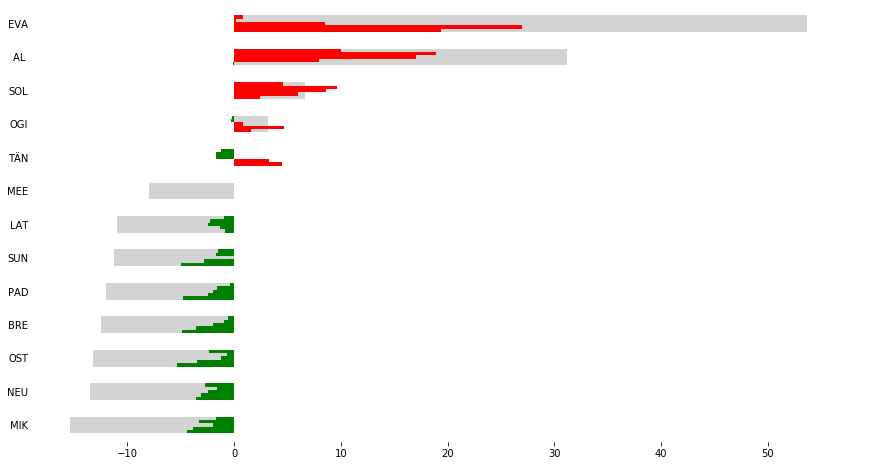

In [643]:
plotSplitSectionDelta(splitdurations,'MEE',total=True,invert_yaxis=False, ignoresplitsfordrivercodes='LAP');

## Running Time Deltas at each split

In [644]:
splits['elapsedDurationS'] = (splits['elapsedDurationMs']/1000).round(1)

#Find the time for the last section - i.e. diff between stage time and final split time
tmp = splits.groupby('drivercode', as_index=False).last()[['drivercode','stageTimeDurationMs','elapsedDurationMs', 'startDateTime' ]]
tmp['elapsedDurationS']=((tmp['stageTimeDurationMs'])/1000).round(1)

cols = ['drivercode','elapsedDurationS', 'startDateTime']
elapseddurations = pd.concat([splits[cols],tmp[cols]]).reset_index(drop=True)
elapseddurations['section'] = elapseddurations.groupby('drivercode').cumcount()+1
elapseddurations = elapseddurations.sort_values(['startDateTime','drivercode','section'])
elapseddurations = elapseddurations
elapseddurations.head()


,drivercode,elapsedDurationS,startDateTime,section
0,OGI,88.1,2018-02-16T08:54:00,1
1,OGI,251.1,2018-02-16T08:54:00,2
2,OGI,409.7,2018-02-16T08:54:00,3
3,OGI,545.5,2018-02-16T08:54:00,4
63,OGI,640.5,2018-02-16T08:54:00,5


In [645]:
order = splits.sort_values(['stageTimeDurationMs','drivercode'])['drivercode'].unique().tolist()

In [646]:
drivercode = 'OGI'

rebase = elapseddurations[elapseddurations['drivercode']==drivercode][['section','elapsedDurationS']].set_index('section').to_dict(orient='dict')['elapsedDurationS']
rebase

{1: 88.1, 2: 251.1, 3: 409.7, 4: 545.5, 5: 640.5}

In [647]:
elapseddurations['rebased']=elapseddurations['elapsedDurationS']-elapseddurations['section'].map(rebase)
elapseddurations['section']=elapseddurations['section']#.astype(str)

In [648]:
order

['MIK',
 'NEU',
 'OST',
 'LAP',
 'BRE',
 'PAD',
 'SUN',
 'LAT',
 'MEE',
 'TÄN',
 'OGI',
 'SOL',
 'AL ',
 'EVA']

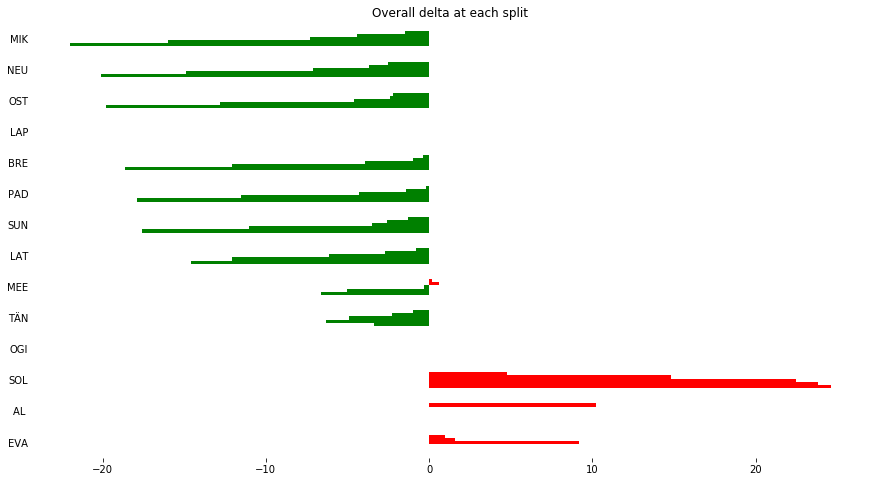

In [649]:
fig, ax = plt.subplots(figsize=(15,8))
ax.yaxis.label.set_visible(False)
ax.tick_params(axis='y', which='both',length=0)


zzz=elapseddurations[elapseddurations['rebased'].abs()<25].pivot('drivercode','section','rebased')
#zz['stagediff']=zz.sum(axis=1)
#zz = zz.sort_values('stagediff',ascending=True).drop(['stagediff'], axis=1)


cmap=[]

    
zzz=zzz.reindex(order)
for col in zzz.columns:
    cmap.append( ['r' if x else 'g' for x in zzz[col]>0 ] )

zzz.plot(kind='barh',title='Overall delta at each split',color=cmap,legend=False,ax=ax).invert_yaxis()

#Hide outer box
plt.box(on=None)

In [650]:
order2=elapseddurations[elapseddurations['section']==elapseddurations['section'].max()].sort_values(['elapsedDurationS','drivercode'])['drivercode'].unique().tolist()
order2

['MIK',
 'NEU',
 'OST',
 'BRE',
 'PAD',
 'SUN',
 'LAT',
 'MEE',
 'TÄN',
 'OGI',
 'SOL',
 'AL ',
 'EVA']

### Make a Function of That

In [651]:
def getElapsedDurations(splits):

    splits['elapsedDurationS'] = (splits['elapsedDurationMs']/1000).round(1)

    #Find the time for the last section - i.e. diff between stage time and final split time
    tmp = splits.groupby('drivercode', as_index=False).last()[['drivercode','stageTimeDurationMs','elapsedDurationMs', 'startDateTime' ]]
    tmp['elapsedDurationS']=((tmp['stageTimeDurationMs'])/1000).round(1)

    cols = ['drivercode','elapsedDurationS', 'startDateTime']
    elapseddurations = pd.concat([splits[cols],tmp[cols]]).reset_index(drop=True)
    elapseddurations['section'] = elapseddurations.groupby('drivercode').cumcount()+1
    elapseddurations = elapseddurations.sort_values(['startDateTime','drivercode','section'])

    return elapsedDurations

def rebaseElapsedDurations(elapseddurations, drivercode=None):
    if drivercode is None: return elapseddurations
    rebase = elapseddurations[elapseddurations['drivercode']==drivercode][['section','elapsedDurationS']].set_index('section').to_dict(orient='dict')['elapsedDurationS']
    elapseddurations['rebased']=elapseddurations['elapsedDurationS']-elapseddurations['section'].map(rebase)
    return elapseddurations

def plotSplitOverallDelta(elapseddurations,drivercode=None, order=None, fig=None, ax=None, alpha=1, pos='r', neg='g',invert_yaxis=True):

    elapseddurations = rebaseElapsedDurations(elapseddurations, drivercode)
    if 'rebased' not in elapseddurations: return
        
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))
        
        ax.yaxis.label.set_visible(False)
        ax.tick_params(axis='y', which='both',length=0)

    zz=elapseddurations[elapseddurations['rebased'].abs()<25].pivot('drivercode','section','rebased')

    cmap=[]

    if order is None:
        order=elapseddurations[elapseddurations['section']==elapseddurations['section'].max()].sort_values(['elapsedDurationS','drivercode'])['drivercode'].unique().tolist()

    zz=zz.reindex(order)
    for col in zz.columns:
        cmap.append( [pos if x else neg for x in zz[col]>0 ] )

    tmp = zz.plot(kind='barh',title='Overall delta at each split',color=cmap,legend=False,ax=ax)

    if invert_yaxis: tmp.invert_yaxis()
        
    #Hide outer box
    plt.box(on=None)
    return fig, ax

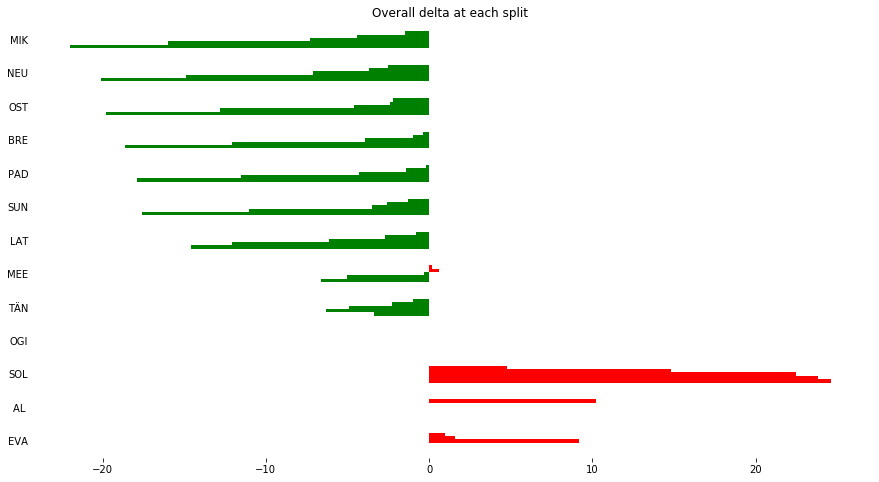

In [652]:
plotSplitOverallDelta(elapseddurations,'OGI');

## Stage Progress

The *stage progress chart* is a deltascope designd to reveal differences arising from, and associated with, a particular stage compared to the previous stage.

In [653]:
def samesign(a,b):
    return (a*b) >0

In [654]:
#want rebased delta if different sign else smaller
#?? if same sign, then return smaller?
def thing(overall,delta):
    if overall<0 and delta<0:
        return overall if overall>delta else delta
    elif overall>0 and delta>0:
        return overall if overall<delta else delta
    return delta
    #return min([a,b], key=abs)

#Return thing closest to zero if samesign, else delta
def thing2(overall,delta):
    if samesign(overall,delta): return min([overall,delta], key=abs)
    return delta

thing(-2,-1.5),thing(1.5,2), thing(2,1.5)

for a,b in [(-1,-0.5),(-0.5,-1),(-0.5,1),(-1,0.5),(0.5,1),(1,0.5)]:
    print(a,b, thing(a,b), thing2(a,b), thing(a,b)==thing2(a,b))

-1 -0.5 -0.5 -0.5 True
-0.5 -1 -0.5 -0.5 True
-0.5 1 1 1 True
-1 0.5 0.5 0.5 True
0.5 1 0.5 0.5 True
1 0.5 0.5 0.5 True


In [655]:
#overall is rebased diff at end of current stage; negative means target is ahead
#prev is rebased diff at end if revious stage; negative means target is ahead
#delta is rebased_curr - rebased_prev; positive means target lost ground
df=pd.DataFrame([{'name':'a','overall':11,'delta':2,'prev':9,'deltax':2},
                {'name':'b','overall':6,'delta':-2,'prev':8,'deltax':-2},
                {'name':'g','overall':8,'delta':12,'prev':-4,'deltax':8},
                {'name':'c','overall':0,'delta':0,'prev':0,'deltax':0},
                {'name':'d','overall':-6,'delta':-2,'prev':-4,'deltax':-2},
                {'name':'e','overall':-8,'delta':2,'prev':-10,'deltax':2},
                {'name':'f','overall':-8,'delta':-12,'prev':4,'deltax':-8},
                ])

df['deltaxx']=df.apply(lambda x: thing(x['overall'],x['delta']), axis=1)
df = df.set_index('name')
df
#if overall and delta have same sign, then use the one closest to 0

,delta,deltax,overall,prev,deltaxx
name,,,,,
a,2,2,11,9,2
b,-2,-2,6,8,-2
g,12,8,8,-4,8
c,0,0,0,0,0
d,-2,-2,-6,-4,-2
e,2,2,-8,-10,2
f,-12,-8,-8,4,-8


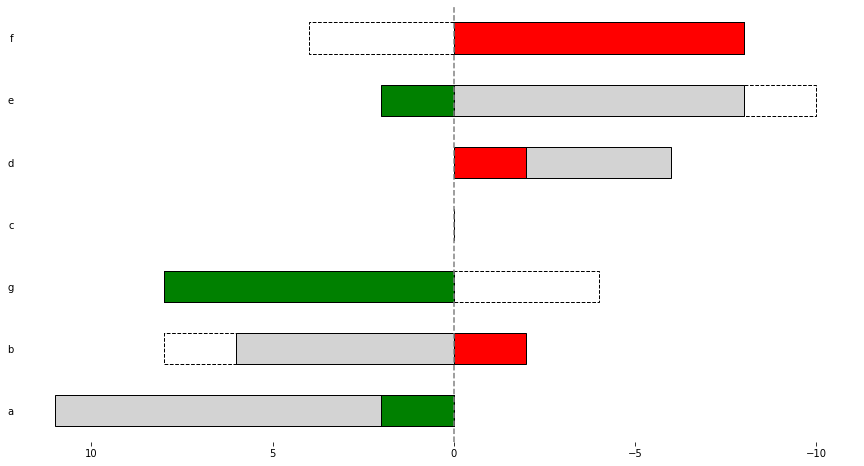

In [656]:
fig, ax = plt.subplots(figsize=(15,8))
ax.yaxis.label.set_visible(False)
ax.tick_params(axis='y', which='both',length=0)

plt.axvline(x=0,linestyle='dashed',color='grey')

df['prev'].plot(kind='barh',edgecolor='black',linestyle='dashed', fill=False, ax=ax)

df['overall'].plot(kind='barh',color='lightgrey',edgecolor='black',ax=ax)
df['deltaxx'].plot(kind='barh',color=['r' if x else 'g' for x in df['deltaxx']<0],edgecolor='black',ax=ax)



ax.invert_xaxis()
#Hide outer box
plt.box(on=None)

How to read the above chart:

- chart is ordered from top down, fastest overall at top;
- x-axis is time delta to other identified cars from a target car; negative bar means target is behind target car by that time;
- green colour shows the target gained time on the stage relative to the identified car, reducing any lead it has over the target, or adding to the gap behind the target;
- red colour shows time was lost on the stage by the target relative to the identified car, adding to any lead that car has over the target, or reducing the gap to a car behind the target;
- a dashed bar shows the situation at the end of the previous stage;

### Exploring Additional Colour Maps

We can use colour to highlight information in different ways. For example, if a target driver loses time to another car, should we colour that other car's delta as red, from the perspective of the target driver that this is a bad thing and we need to be warned about it, or green, as it might be displayed on a "global" timing screen to show that the other car has made time on the target car?

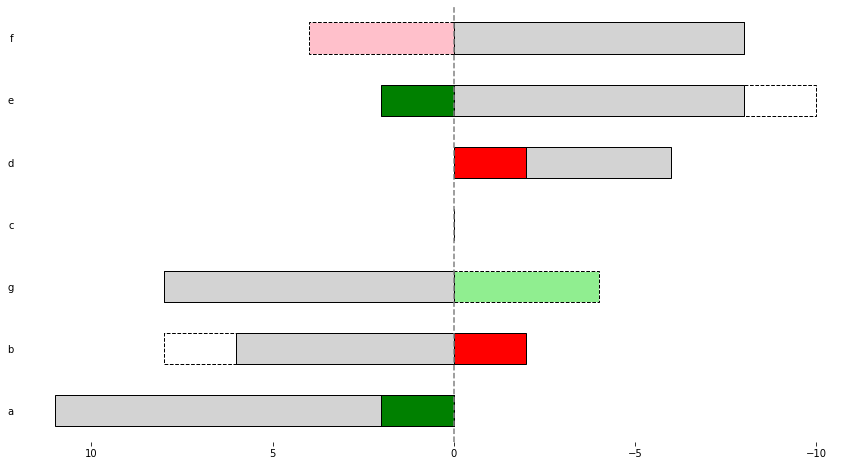

In [657]:
fig, ax = plt.subplots(figsize=(15,8))
ax.yaxis.label.set_visible(False)
ax.tick_params(axis='y', which='both',length=0)

plt.axvline(x=0,linestyle='dashed',color='grey')


#Let's start trying to figure out color maps
def colmap1(a,b):
    if a==b: return 'lightgrey'
    else: return 'r' if b<0 else 'g'
        
def colmap2(a,b):
    if not samesign(a,b): return 'w'
    else: return 'pink' if b<0 else 'lightgreen'

df['prev'].plot(kind='barh', color=df.apply(lambda x: colmap2(x['overall'],x['deltaxx']),axis=1),edgecolor='w',ax=ax)
df['prev'].plot(kind='barh',edgecolor='black',linestyle='dashed', fill=False, ax=ax)

df['overall'].plot(kind='barh',color='lightgrey',edgecolor='black',ax=ax)
#df['deltaxx'].plot(kind='barh',color=['r' if x else 'g' for x in df['deltaxx']<0],edgecolor='black',ax=ax)
df['deltaxx'].plot(kind='barh',color=df.apply(lambda x: colmap1(x['overall'],x['deltaxx']),axis=1),edgecolor='black',ax=ax)


ax.invert_xaxis()
#Hide outer box
plt.box(on=None)

So what do we need for this sort of chart?

- drivercode;
- total accumulated time at end of previous stage;
- total accumulated time at end of current stage;
- rebased differences from each driver to a target driver for previous and current stage;
- delta for each driver based on rebased difference times from previous and current stages.


In [658]:
snum=4
typ='stage_times_overall'

#this represents a subset of dbGetStageRank in "Charts - Stage Results.ipynb"
#use that function instead?
def getStageResult( rally, typ, snum, rc):
    q='''
    SELECT st.totalTimeMs, sc.name as class, i.code, i.distance, i.name, CAST(REPLACE(code,'SS','') AS INTEGER) snum,
    sl.`driver.code`, sl.`entrant.name`
    FROM {typ} st INNER JOIN itinerary_stages i ON st.stageId = i.stageId
    INNER JOIN startlist_classes sc ON sc.entryid = st.entryId 
    INNER JOIN championship_events ce ON i.eventId=ce.eventId
    INNER JOIN startlists sl ON sl.entryId=sc.entryId
    WHERE sc.name="{rc}" AND ce.`country.name`="{rally}" AND snum={stage} ORDER BY snum
    '''.format(rc=rc,rally=rally, typ=typ, stage=snum)
    return pd.read_sql(q,conn)

curr = getStageResult( rally, typ, snum, rc)
curr['snum'] = 'curr'
prev = getStageResult( rally, typ, snum-1, rc)
prev['snum'] = 'prev'

stagerank= pd.concat([curr,prev]).reset_index(drop=True)
stagerank.head(3)

,totalTimeMs,class,code,distance,name,snum,driver.code,entrant.name
0,2149700,RC1,SS4,19.13,SS4 Röjden 1,curr,NEU,HYUNDAI SHELL MOBIS WRT
1,2153400,RC1,SS4,19.13,SS4 Röjden 1,curr,MIK,HYUNDAI SHELL MOBIS WRT
2,2155000,RC1,SS4,19.13,SS4 Röjden 1,curr,LAP,TOYOTA GAZOO RACING WRT


In [659]:
dfx = stagerank.pivot('driver.code','snum','totalTimeMs')
dfx

snum,curr,prev
driver.code,,
AL,2386400,1698800
BRE,2164700,1542800
EVA,2247400,1557600
LAP,2155000,1533600
LAT,2166700,1540800
MEE,2188400,1554500
MIK,2153400,1534900
NEU,2149700,1529300
OGI,2197400,1556900


In [660]:
drivercode = 'TÄN'
#drivercode = 'LAT'
#drivercode = 'PAD'

In [661]:
rebase = dfx.loc[drivercode].to_dict()
rebase

{'curr': 2169100, 'prev': 1532000}

In [662]:
#rebased_curr is rebased diff at end of current stage; negative means target is ahead
#rebased_prev is rebased diff at end if revious stage; negative means target is ahead
#rebased_delta is rebased_curr - rebased_prev; positive means target lost ground

In [663]:
dfx['rebased_curr'] = ((dfx['curr'] - rebase['curr'])/1000).round(1)
dfx['rebased_prev'] = ((dfx['prev'] - rebase['prev'])/1000).round(1)
dfx['rebased_delta'] = dfx['rebased_curr'] - dfx['rebased_prev']

dfx['deltaxx']=dfx.apply(lambda x: thing(x['rebased_curr'],x['rebased_delta']), axis=1)

dfx

snum,curr,prev,rebased_curr,rebased_prev,rebased_delta,deltaxx
driver.code,,,,,,
AL,2386400,1698800,217.3,166.8,50.5,50.5
BRE,2164700,1542800,-4.4,10.8,-15.2,-4.4
EVA,2247400,1557600,78.3,25.6,52.7,52.7
LAP,2155000,1533600,-14.1,1.6,-15.7,-14.1
LAT,2166700,1540800,-2.4,8.8,-11.2,-2.4
MEE,2188400,1554500,19.3,22.5,-3.2,-3.2
MIK,2153400,1534900,-15.7,2.9,-18.6,-15.7
NEU,2149700,1529300,-19.4,-2.7,-16.7,-16.7
OGI,2197400,1556900,28.3,24.9,3.4,3.4


### Make a function of the original stage progress chart

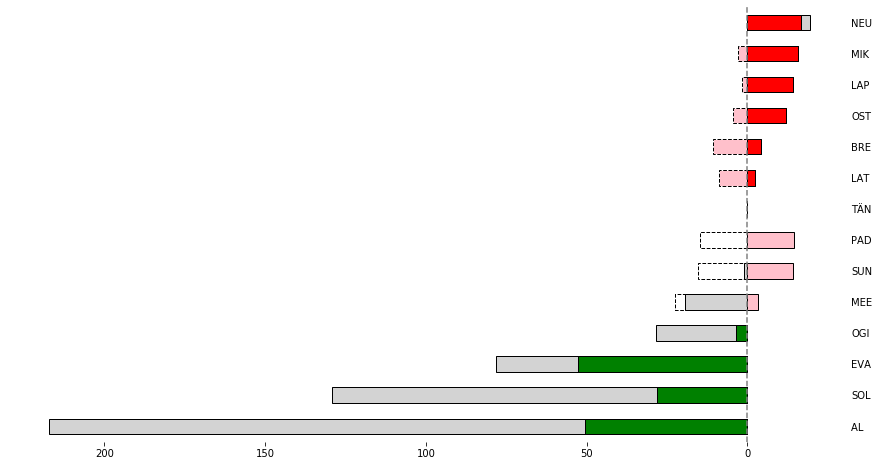

In [664]:
def stageProgessBarOrig(df,prev,curr,delta,deltaxx,title=None):
    df = df.sort_values(curr,ascending=False)
    
    fig, ax = plt.subplots(figsize=(15,8))
    ax.yaxis.label.set_visible(False)
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', which='both',length=0)

    plt.axvline(x=0,linestyle='dashed',color='grey')

    
    #Thre previous colour maps weren't quite correct
    def colmap3(row):
        if not samesign(row[deltaxx], row[curr]): return 'w'
        return 'pink' if row[curr]<row[prev] else 'lightgreen'

    def colmap4(row):
        #if not samesign(row[delta], row[deltaxx]): return 'lightgrey'    
        if not samesign(row[curr],row[delta]):
            return 'pink' if (row[deltaxx]<0) else 'lightgreen'
        return 'r' if (row[deltaxx]<0) else 'g'

    df[prev].plot(kind='barh', color=df.apply(lambda x: colmap3(x),axis=1),edgecolor='w',ax=ax)
    df[prev].plot(kind='barh',edgecolor='black',linestyle='dashed', fill=False, ax=ax)
    #df[prev].plot(kind='barh',edgecolor='black', fill=False, ax=ax)
    df[curr].plot(kind='barh',color='lightgrey',edgecolor='black',ax=ax)
    
    df[deltaxx].plot(kind='barh',color=df.apply(lambda x: colmap4(x),axis=1),edgecolor='black',ax=ax)
    

    ax.invert_xaxis()
    #Hide outer box
    plt.box(on=None)
    if title: plt.title(title)

#MEE needs to be pink,
stageProgessBarOrig(dfx,'rebased_prev','rebased_curr','rebased_delta','deltaxx')

## An Improved Stage Progress Chart

...

In [665]:
def rebaseStageRankProgress(stagerank, drivercode):   
    dfx = stagerank.pivot('driver.code','snum','totalTimeMs')

    rebase = dfx.loc[drivercode].to_dict()
    dfx['rebased_curr'] = ((dfx['curr'] - rebase['curr'])/1000).round(1)
    dfx['rebased_prev'] = ((dfx['prev'] - rebase['prev'])/1000).round(1)
    dfx['rebased_delta'] = dfx['rebased_curr'] - dfx['rebased_prev']

    dfx['deltaxx']=dfx.apply(lambda x: thing(x['rebased_curr'],x['rebased_delta']), axis=1)
    return dfx

In [666]:
def stageProgessBar(df,prev,curr,delta,deltaxx,title=None, neg='r',pos='g', lneg='pink',lpos='lightgreen'):
    
    #df = df.sort_values(curr,ascending=False)
    
    fig, ax = plt.subplots(figsize=(15,8))
    ax.yaxis.label.set_visible(False)
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', which='both',length=0)

    plt.axvline(x=0,linestyle='dashed',color='grey')

    
    #The previous colour maps weren't quite correct
    def colmap3(row):
        if not samesign(row[deltaxx], row[curr]): return 'w'
        return lneg if row[curr]<row[prev] else lpos

    def colmap4(row):
        #if not samesign(row[delta], row[deltaxx]): return 'lightgrey'    
        if not samesign(row[curr],row[delta]):
            return lneg if (row[deltaxx]<0) else lpos
        return neg if (row[deltaxx]<0) else pos
    
    def colmap5(row):
        if not samesign(row[deltaxx], row[curr]): return 'w'
        return neg if row[curr]<row[prev] else pos

    df[prev].plot(kind='barh', color=df.apply(lambda x: colmap5(x),axis=1),edgecolor='w',ax=ax)
    #df[prev].plot(kind='barh',edgecolor='black',linestyle='dashed', fill=False, ax=ax)
    df[prev].plot(kind='barh',edgecolor='black', fill=False, ax=ax)
    df[curr].plot(kind='barh',color='lightgrey',edgecolor='black',ax=ax)
    
    df[deltaxx].plot(kind='barh',color=df.apply(lambda x: colmap4(x),axis=1),edgecolor='black',ax=ax) 

    ax.invert_xaxis()
    #Hide outer box
    plt.box(on=None)
    if title: plt.title(title)
        
    return fig,ax

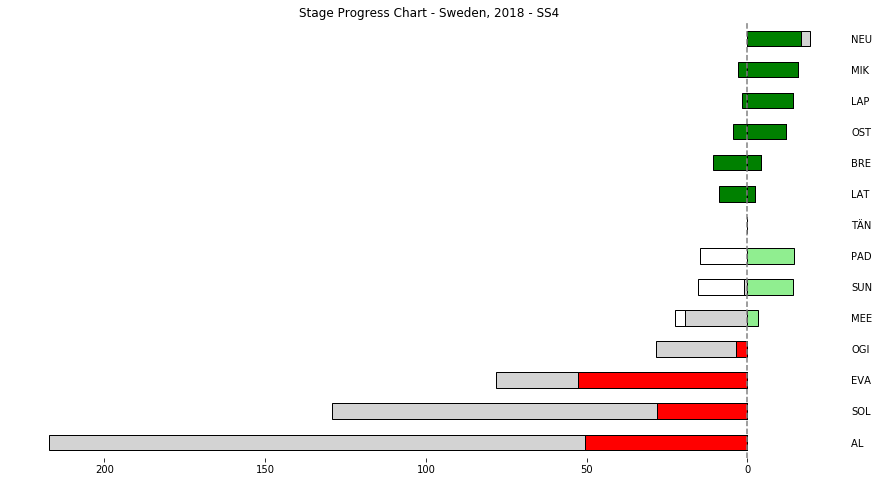

In [667]:
def rebaseStageProgressBar(stagerank, drivercode, title=None,neg='green',pos='r', lneg='lightgreen',lpos='pink', overlay=False):   
    dfx = rebaseStageRankProgress(stagerank, drivercode)
    dfx = dfx.sort_values('rebased_curr',ascending=False)
    
    fig, ax = stageProgessBar(dfx,'rebased_prev','rebased_curr','rebased_delta','deltaxx',title=title, neg=neg,lneg=lneg,pos=pos,lpos=lpos)

    if overlay:
        fig,ax=plotSplitSectionDelta(splitdurations,drivercode,dfx.index,fig,ax,alpha=0.7,invert_yaxis=False);
    
    return fig, ax

#rebaseStageProgressBar(stagerank,'TÄN', title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,rally=rally,ss=str(snum).replace('SS','')))
#rebaseStageProgressBar(stagerank,'PAD', title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,rally=rally,ss=str(snum).replace('SS','')))
#rebaseStageProgressBar(stagerank,'OST', title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,rally=rally,ss=str(snum).replace('SS','')))
fig, ax = rebaseStageProgressBar(stagerank,'TÄN', title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,rally=rally,ss=str(snum).replace('SS','')));


Solid color shows we are consolidating a position. Pastel colour shows that there has been a gain or loss on leader/laggard.

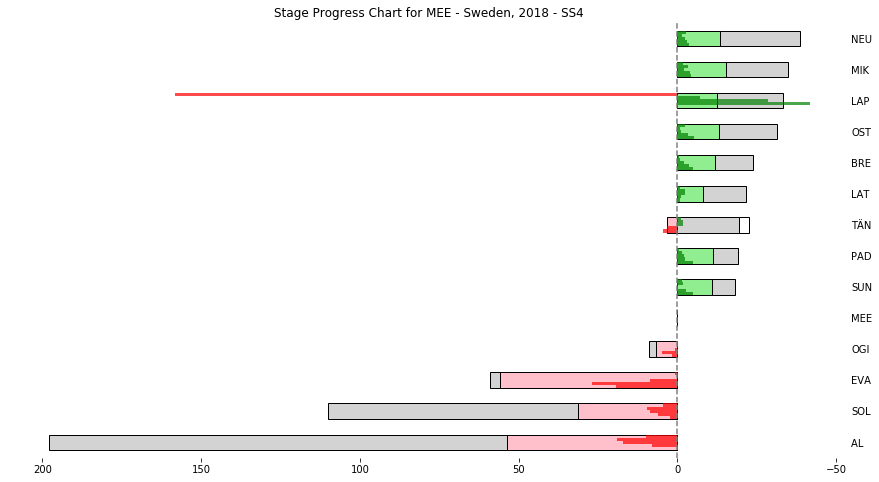

In [668]:
drivercode='MEE'#'TÄN'
fig, ax = rebaseStageProgressBar(stagerank,drivercode, neg='lightgreen',pos='pink',
                                 title='Stage Progress Chart for {dc} - {rally}, {year} - SS{ss}'.format(dc=drivercode,
                                                                                                         year=year,
                                                                                                         rally=rally,
                                                                                                         ss=str(snum).replace('SS','')));

dfx = rebaseStageRankProgress(stagerank, drivercode)
dfx = dfx.sort_values('rebased_curr',ascending=False)
order = dfx.index
fig,ax=plotSplitSectionDelta(splitdurations,drivercode,order,fig,ax,alpha=0.7,invert_yaxis=False);

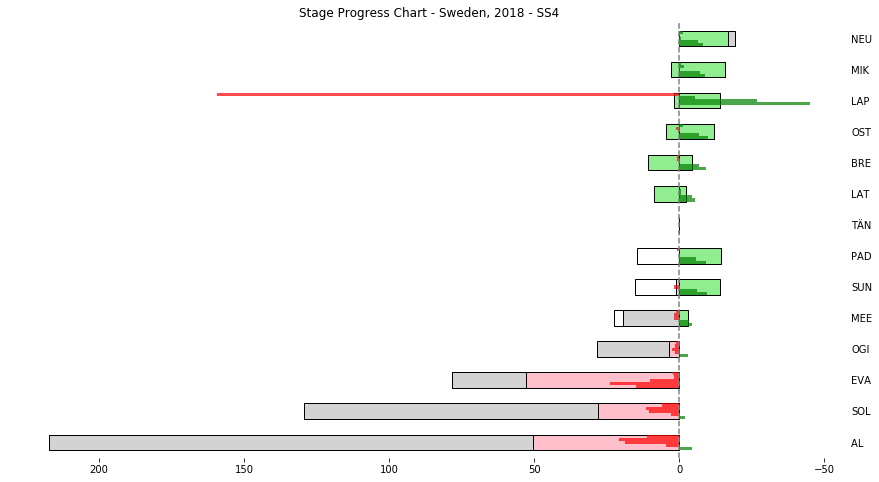

In [669]:
fig, ax = rebaseStageProgressBar(stagerank,'TÄN', overlay=True,neg='lightgreen',pos='pink',
                                 title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,rally=rally,ss=str(snum).replace('SS','')));
fig.savefig('test1.png')   # save the figure to file
#plt.close(fig)  

## Test Outputter

In [670]:
#!/Users/ajh59/anaconda3/bin/conda install -y unidecode
#In some cases we may want to remove unicode characters and use a simple ascii equivalent
import unidecode
unidecode.unidecode('TÄN')

'TAN'

In [671]:
txt=''
!mkdir -p testout/img
path='testout/'
with open('{}testfile1.md'.format(path), 'w') as file:
    for dc in stagerank['driver.code'].unique():
        fig, ax = rebaseStageProgressBar(stagerank,dc, overlay=True,neg='lightgreen',pos='pink',
                                 title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,
                                                                                                rally=rally,
                                                                                                ss=str(snum).replace('SS','')));
        img='img/test_{}_{}.png'.format(str(snum).replace('SS',''), unidecode.unidecode(dc))
        fig.savefig('{}{}'.format(path,img))   # save the figure to file
        plt.close(fig)  
        file.write('# Stage Progress Chart - {rally}, {year} - {dc} - SS{ss}\n\n'.format(year=year,rally=rally,
                                                                              dc=dc,
                                                                              ss=str(snum).replace('SS','')))
        file.write('![]({})\n'.format(img))

        

Here's a test fig:

![](test1.png)

In [672]:
rebaseSplitDurations(splitdurations, drivercode).pivot('drivercode','section','rebased')

section,1,2,3,4,5
drivercode,,,,,
AL,10.0,18.9,17.0,7.9,-0.1
BRE,-0.6,-1.0,-2.0,-3.6,-4.9
EVA,0.8,0.2,8.5,27.0,19.4
LAP,158.2,-7.1,-28.5,-41.7,NaN
LAT,-1.0,-2.3,-2.5,-1.3,-0.9
MEE,0.0,0.0,0.0,0.0,0.0
MIK,-1.7,-3.3,-2.0,-3.9,-4.4
NEU,-2.7,-1.6,-2.5,-3.1,-3.6
OGI,-0.2,-0.3,0.8,4.7,1.6


In [673]:
splitdurations.head()

,drivercode,splitDurationS,startDateTime,stageTimeDurationMs,section,rebased
0,OGI,88.1,2018-02-16T08:54:00,640500.0,1,-0.2
1,OGI,163.1,2018-02-16T08:54:00,640500.0,2,-0.3
2,OGI,158.5,2018-02-16T08:54:00,640500.0,3,0.8
3,OGI,135.8,2018-02-16T08:54:00,640500.0,4,4.7
63,OGI,95.0,2018-02-16T08:54:00,640500.0,5,1.6


In [674]:
splitdurations = getSplitDurationsFromSplits(conn,rally,ss,rc='RC1')

splitdurations.head(10)

,drivercode,splitDurationS,startDateTime,stageTimeDurationMs,section
0,OGI,88.1,2018-02-16T08:54:00,640500.0,1
1,OGI,163.1,2018-02-16T08:54:00,640500.0,2
2,OGI,158.5,2018-02-16T08:54:00,640500.0,3
3,OGI,135.8,2018-02-16T08:54:00,640500.0,4
63,OGI,95.0,2018-02-16T08:54:00,640500.0,5
4,TÄN,87.1,2018-02-16T08:55:00,637100.0,1
5,TÄN,161.7,2018-02-16T08:55:00,637100.0,2
6,TÄN,156.0,2018-02-16T08:55:00,637100.0,3
7,TÄN,134.4,2018-02-16T08:55:00,637100.0,4
68,TÄN,97.9,2018-02-16T08:55:00,637100.0,5


In [675]:
ignoresplitsfordrivercodes=['LAP']
if ignoresplitsfordrivercodes is not None:
    ignoresplitsfordrivercodes = [ignoresplitsfordrivercodes] if not isinstance(ignoresplitsfordrivercodes,list) else ignoresplitsfordrivercodes
    splitdurations = splitdurations[~splitdurations['drivercode'].isin(ignoresplitsfordrivercodes)].copy()

In [676]:
splitdurations['sectorrank']=splitdurations.groupby(['section'])['splitDurationS'].rank(method='dense').astype(int)
splitdurations.head()

,drivercode,splitDurationS,startDateTime,stageTimeDurationMs,section,sectorrank
0,OGI,88.1,2018-02-16T08:54:00,640500.0,1,9
1,OGI,163.1,2018-02-16T08:54:00,640500.0,2,7
2,OGI,158.5,2018-02-16T08:54:00,640500.0,3,6
3,OGI,135.8,2018-02-16T08:54:00,640500.0,4,10
63,OGI,95.0,2018-02-16T08:54:00,640500.0,5,10


In [677]:
order = splits.sort_values(['stageTimeDurationMs','drivercode'])['drivercode'].unique().tolist()

In [678]:
#splitdurations = rebaseSplitDurations(splitdurations, drivercode='MIK')
splitdurations = rebaseSplitDurationsBest(splitdurations)
splitdurations.head()

,drivercode,splitDurationS,startDateTime,stageTimeDurationMs,section,sectorrank,rebased,sectorBestDriver
0,OGI,88.1,2018-02-16T08:54:00,640500.0,1,9,2.5,NEU
1,OGI,163.1,2018-02-16T08:54:00,640500.0,2,7,3.0,MIK
2,OGI,158.5,2018-02-16T08:54:00,640500.0,3,6,3.3,NEU
3,OGI,135.8,2018-02-16T08:54:00,640500.0,4,10,8.6,MIK
63,OGI,95.0,2018-02-16T08:54:00,640500.0,5,10,7.0,OST


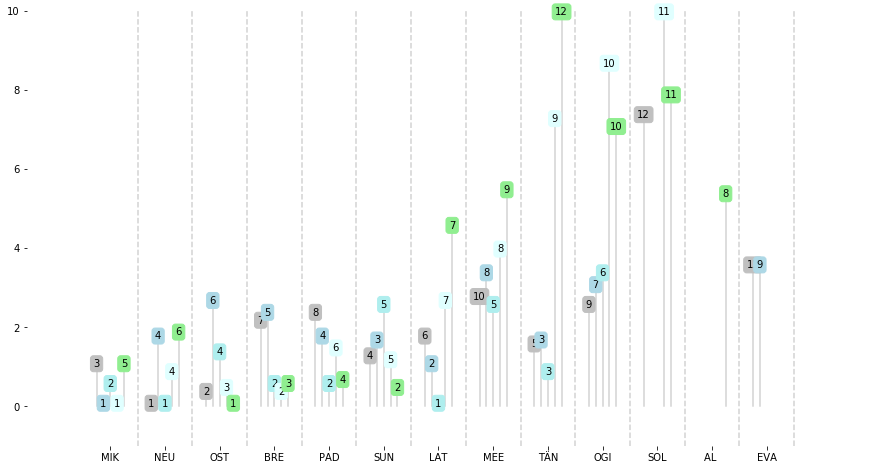

In [679]:
from statsmodels.graphics import utils
from numpy import arange

order = getSplitOrderByStageTimeDuration(splitdurations)
splitdurationsbydriver=splitdurations.groupby('drivercode')

ydim='rebased'


labdim = 'sectorrank'
ylabel=None
xticklabels=None
label=True
ylim=(-1,10)
keyHighlight=None#'leader'#None
fig, ax = plt.subplots(figsize=(15,8))

#fig, ax = utils.create_mpl_ax(ax)
        
start = 0
ticks = []
tmpxlabels = []
for key in order:
    df=splitdurationsbydriver.get_group(key)
    nobs = len(df)
    x_plot = arange(start, start + nobs)
    ticks.append(x_plot.mean())
    #Third parameter is color; 'k' is black
    #ax.plot(x_plot, df[ydim], 'g', linestyle='--')

    #named colors: http://matplotlib.org/examples/color/named_colors.html
    highlightColors=['mistyrose','lightsalmon','salmon','tomato','orangered']
    baseColors=['silver','lightblue','paleturquoise','lightcyan','lightgreen']
    if key==keyHighlight:
        colors=highlightColors
    else:
        colors=baseColors
    for i in range(0,nobs):
        if ylim is not None and (df[ydim].iloc[i]<=ylim[0] or df[ydim].iloc[i]>=ylim[1]): continue
        if label:
            if nobs<=len(colors):
                if keyHighlight=='leader':
                    if int(df[labdim].iloc[i])==1: color=highlightColors[i-nobs]
                    else: color=baseColors[i-nobs]
                else:
                    color=colors[i-nobs]
            else: color='pink'
            ax.plot((x_plot[i],x_plot[i]), (0,df[ydim].iloc[i]), 'lightgrey')
            ax.text(x_plot[i], df[ydim].iloc[i], int(df[labdim].iloc[i]),
                    bbox=dict(  boxstyle='round,pad=0.3',color=color),horizontalalignment='center')
        else:
            pass
            #ax.plot(x_plot[i], df[labdim].iloc[i], 'or')
        
    start += nobs+3
    plt.axvline(x=start-2,linestyle='dashed',color='lightgrey')
    tmpxlabels.append(key)
    
if xticklabels is None:
    xticklabels=tmpxlabels
elif isinstance(xticklabels, dict):
    xticklabels=[xticklabels[x] if x in xticklabels else x for x in tmpxlabels]
ax.set_xticks(ticks)
ax.set_xticklabels(xticklabels)
if ylabel is not None: ax.set_ylabel(ylabel)
    
if ylim is not None: ax.set_ylim(ylim)
ax.margins(.1, .05)

plt.box(on=None)

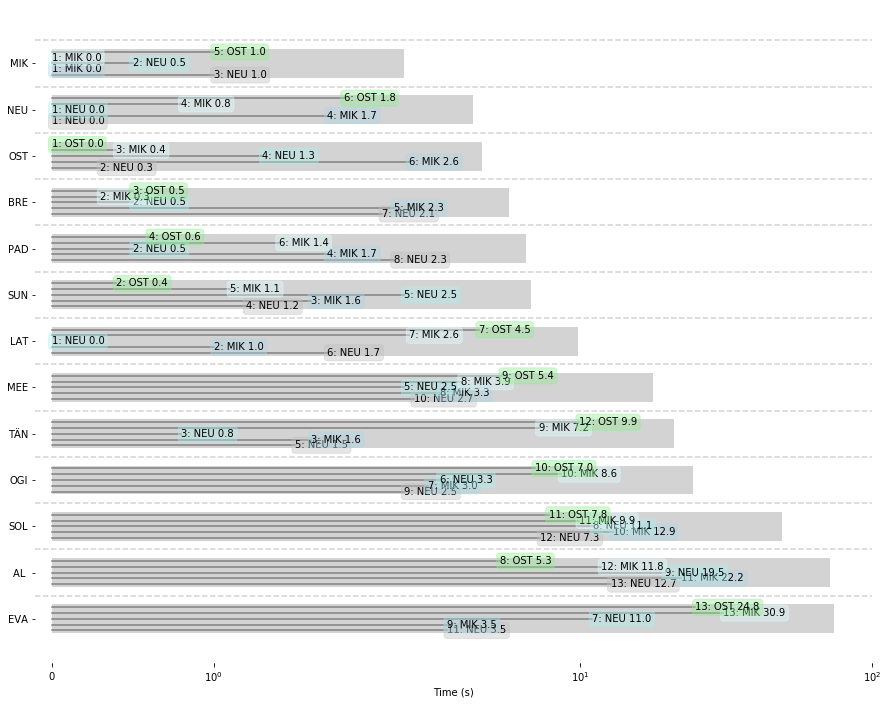

In [687]:
from pylab import barh

#swap x and y
labdim = 'sectorrank'
timelabel='Time (s)'
driverlabels=None
label=True
timelim=(-0.1,100)
keyHighlight=None#'leader'#None
fig, ax = plt.subplots(figsize=(15,12))


order = getSplitOrderByStageTimeDuration(splitdurations)
splitdurationsbydriver=splitdurations.groupby('drivercode')

#fig, ax = utils.create_mpl_ax(ax)

timedim='rebased'

splitdurations['stageTimeDurationS']=(splitdurations['stageTimeDurationMs']/1000).round(1)
tmp=splitdurations[['stageTimeDurationS','drivercode']].drop_duplicates()#.plot(kind='barh',ax=ax)

start = 0
ticks = []
tmpxlabels = []
for key in order[::-1]:
    df=splitdurationsbydriver.get_group(key)
    nobs = len(df)
    driver_plot = arange(start, start + nobs)
    ticks.append(driver_plot.mean())
    #Third parameter is color; 'k' is black
    #ax.plot(x_plot, df[ydim], 'g', linestyle='--')
    #?so how can we plot bars underneath this chart?
    ax.barh(start+2, df['rebased'].sum(), len(df), color='lightgrey')
    
    #named colors: http://matplotlib.org/examples/color/named_colors.html
    highlightColors=['mistyrose','lightsalmon','salmon','tomato','orangered']
    baseColors=['silver','lightblue','paleturquoise','lightcyan','lightgreen']
    if key==keyHighlight:
        colors=highlightColors
    else:
        colors=baseColors
    for i in range(0,nobs):
        ax.plot( (0, df[ydim].iloc[i]),(driver_plot[i],driver_plot[i]), 'grey')
        #if timelim is not None and (df[timedim].iloc[i]<=timelim[0] or df[timedim].iloc[i]>=timelim[1]): continue
        if label:
            if nobs<=len(colors):
                if keyHighlight=='leader':
                    if int(df[labdim].iloc[i])==1: color=highlightColors[i-nobs]
                    else: color=baseColors[i-nobs]
                else:
                    color=colors[i-nobs]
            else: color='pink'
            if timelim is not None and df[timedim].iloc[i]>=timelim[1]:
                timemax = timelim[1]
            else:
                timemax = df[timedim].iloc[i]
            ax.text(timemax,driver_plot[i],  
                    '{}: {} {}'.format(int(df[labdim].iloc[i]),df['sectorBestDriver'].iloc[i],df[timedim].iloc[i].round(1) ),
                    bbox=dict(  boxstyle='round,pad=0.3',color=color, alpha=0.4), #circle | round
                    verticalalignment='center', horizontalalignment='left')
        else:
            pass
            #ax.plot(x_plot[i], df[labdim].iloc[i], 'or')
        
    start += nobs+3
    plt.axhline(y=start-2,linestyle='dashed',color='lightgrey')
    tmpxlabels.append(key)
    
if driverlabels is None:
    driverlabels=tmpxlabels
elif isinstance(driverlabels, dict):
    driverlabels=[driverlabels[x] if x in driverlabels else x for x in tmpxlabels]
ax.set_yticks(ticks)
ax.set_yticklabels(driverlabels)
if timelabel is not None: ax.set_xlabel(timelabel)
    
if timelim is not None: ax.set_xlim(timelim)
ax.margins(.1, .05)
plt.box(on=None)
plt.rc('font', size=10)
plt.xscale('symlog')
#This chart shows the time left on the table - the delta to the ultimate stage
#in the label could add the name of the driver with best time
#alternatively, pass in a target name of someone you are interested in?

In [681]:
xticklabels

['MIK',
 'NEU',
 'OST',
 'BRE',
 'PAD',
 'SUN',
 'LAT',
 'MEE',
 'TÄN',
 'OGI',
 'SOL',
 'AL ',
 'EVA']

In [682]:
dbname='mexico18.db'
rally='Mexico'
snum=3
rc='RC1'
typ='stage_times_overall'
conn = sqlite3.connect(dbname)
currm = getStageResult( rally, typ, snum, rc)
currm['snum'] = 'curr'
prevm = getStageResult( rally, typ, snum-1, rc)
prevm['snum'] = 'prev'

stagerankm= pd.concat([currm,prevm])

In [683]:
fig, ax = rebaseStageProgressBar(stagerankm,'TÄN',lg='pink',p='lightgreen',r='g',g='r', title='Stage Progress Chart - {rally}, {year} - SS{ss}'.format(year=year,rally=rally,ss=str(snum).replace('SS','')));


TypeError: rebaseStageProgressBar() got an unexpected keyword argument 'lg'

In [684]:
q='''
SELECT *
FROM {typ} st INNER JOIN itinerary_stages i ON st.stageId = i.stageId
INNER JOIN startlist_classes sc ON sc.entryid = st.entryId 
INNER JOIN championship_events ce ON i.eventId=ce.eventId
INNER JOIN startlists sl ON sl.entryId=sc.entryId

'''.format(rc=rc,rally=rally, typ=typ, stage=snum)
aa=pd.read_sql(q,conn)
aa.head()

,diffFirst,diffFirstMs,diffPrev,diffPrevMs,entryId,penaltyTime,penaltyTimeMs,position,stageTime,stageTimeMs,...,manufacturer.name,manufacturerId,priority,status,tag,tag.name,tag.tagId,tagId,tyreManufacturer,vehicleModel
0,PT0S,0,PT0S,0,1761,PT0S,0,1,PT2M6.7S,126700,...,Hyundai,33,P1,Entry,None,None,NaN,NaN,Michelin,i20 Coupe WRC
1,PT1.9S,1900,PT1.9S,1900,1764,PT0S,0,2,PT2M8.6S,128600,...,Toyota,84,P1,Entry,None,None,NaN,NaN,Michelin,Yaris WRC
2,PT2S,2000,PT0.1S,100,1757,PT0S,0,3,PT2M8.7S,128700,...,Ford,26,P1,Entry,None,None,NaN,NaN,Michelin,Fiesta WRC
3,PT2.5S,2500,PT0.5S,500,1763,PT0S,0,4,PT2M9.2S,129200,...,Toyota,84,P1,Entry,None,None,NaN,NaN,Michelin,Yaris WRC
4,PT2.9S,2900,PT0.4S,400,1765,PT0S,0,5,PT2M9.6S,129600,...,Toyota,84,P1,Entry,None,None,NaN,NaN,Michelin,Yaris WRC
